## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [39]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [40]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [41]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [42]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [43]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [44]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [45]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [46]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [47]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [48]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [49]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [50]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================

# === NÂNG CẤP LỚN: Plan Delegator với "Kinh nghiệm Sư phạm" ===
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v10.0 - Nhà hoạch định Thông thái) đang triển khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Bắt đầu lại với agent_outputs sạch sẽ mỗi khi lập kế hoạch lại
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Nhà Hoạch định Sư phạm giàu kinh nghiệm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách các nhiệm vụ cụ thể, với sự phân bổ thời gian THỰC TẾ và KHẢ THI.

    **BẢN THIẾT KẾ SƯ PHẠM:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **BẢNG TRA CỨU KINH NGHIỆM SƯ PHẠM (THAM KHẢO BẮT BUỘC):**
    - Khởi động/Khám phá: ~10-15 phút.
    - Xây dựng kiến thức (mỗi khái niệm lớn): ~15-20 phút.
    - Thực hành/Hoạt động nhóm: ~20-30 phút.
    - Luyện tập/Củng cố: ~15-20 phút.
    - Tổng kết/Đánh giá/Giao bài tập: ~5-10 phút.

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **PHÂN BỔ THỰC TẾ:** Dựa vào Bảng tra cứu kinh nghiệm, hãy phân bổ thời gian cho từng nhiệm vụ một cách hợp lý.
    2.  **TUÂN THỦ TỔNG THỜI GIAN:** Tổng thời lượng của tất cả các nhiệm vụ cộng lại PHẢI bằng chính xác **{total_duration} phút**.
    
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# === NÂNG CẤP LỚN: Critic trở thành "Người bảo vệ Kế hoạch" ===
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Người Bảo vệ Kế hoạch, nhiệm vụ của bạn là đảm bảo các hoạt động được tạo ra phải TUÂN THỦ KẾ HOẠCH GỐC.
    **KẾ HOẠCH GỐC ĐÃ BAN HÀNH:**
    - Nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Thời gian cho phép: **{estimated_duration} phút.**

    **NỘI DUNG CẦN THẨM ĐỊNH:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **CÁC BƯỚC SUY LUẬN:**
    1.  **Kiểm tra Chất lượng:** Nội dung có chính xác chuyên môn và phù hợp sư phạm không? Nếu có lỗi, `is_valid: false`.
    2.  **Kiểm tra Tuân thủ Thời gian (QUAN TRỌNG NHẤT):** Dựa vào mô tả các bước trong nội dung, hãy ước tính xem hoạt động này có thực sự có thể hoàn thành trong **{estimated_duration} phút** hay không.
        - Nếu có thể hoàn thành, `is_valid: true`.
        - Nếu nội dung quá chi tiết, nhiều bước, và rõ ràng sẽ mất nhiều thời gian hơn so với kế hoạch, `is_valid: false`.

    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu hợp lệ và tuân thủ kế hoạch: `is_valid: true`, `feedback: "Nội dung hợp lệ."`.
    - Nếu không hợp lệ (lỗi chất lượng hoặc thời gian): `is_valid: false`, `feedback` phải giải thích rõ tại sao nội dung không tuân thủ kế hoạch và đưa ra mệnh lệnh: **"Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian {estimated_duration} phút đã cho."** TUYỆT ĐỐI KHÔNG đề xuất tăng thời gian (`suggested_duration` phải là null).
    """
    # Sử dụng ValidationResult nhưng sẽ bỏ qua suggested_duration
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!")
            return {"validation_feedback": None}
        else:
            # Loại bỏ suggested_duration nếu có
            clean_feedback = result.feedback.split("|")[0].strip()
            print_warning(f"GUARDIAN PHẢN BIỆN: {clean_feedback}")
            return {"validation_feedback": clean_feedback}
    except Exception as e:
        print_warning(f"Lỗi tại Guardian Critic: {e}. Mặc định cho qua.")
        return {"validation_feedback": None}

# === NÂNG CẤP LỚN: Specialist Agent với "Tư duy Kỷ luật" ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v10.0) đang tạo nội dung theo kỷ luật...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    if state.get('validation_feedback'):
        feedback_prompt = f"""
        **MỆNH LỆNH TỪ NGƯỜI BẢO VỆ (BẮT BUỘC SỬA):**
        "{state.get('validation_feedback', '')}"
        Điều này có nghĩa là phiên bản trước của bạn quá phức tạp. Hãy tạo một phiên bản **đơn giản hơn, ít bước hơn, hoặc ít câu hỏi hơn** để đảm bảo nó có thể hoàn thành trong thời gian cho phép.
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo, tuân thủ nghiêm ngặt kế hoạch được giao.
    
    **KẾ HOẠCH ĐÃ BAN HÀNH:**
    - Tên nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - **THỜI GIAN TỐI ĐA (MỆNH LỆNH TUYỆT ĐỐI):** {task_to_run.get('estimated_duration', 10)} phút.

    {feedback_prompt}
    
    **QUY TẮC SỐ 1 - KỶ LUẬT THỜI GIAN:**
    Nhiệm vụ của bạn là **co giãn nội dung cho vừa với thời gian, không phải co giãn thời gian cho vừa với nội dung**. Hãy thiết kế hoạt động tốt nhất có thể trong giới hạn thời gian đã cho. Nếu cần, hãy giảm bớt số lượng bài tập, rút ngắn các bước, hoặc đơn giản hóa yêu cầu. **TUYỆT ĐỐI KHÔNG** tạo ra một hoạt động mà bạn biết sẽ mất nhiều thời gian hơn quy định.
    
    **CÁC QUY TẮC KHÁC:**
    - **CẤU TRÚC LÕI/MỞ RỘNG:** Phân chia hoạt động thành phần cốt lõi (phải hoàn thành) và phần mở rộng (nếu còn thời gian).
    - **TUÂN THỦ SCHEMA:** Trả về JSON theo đúng cấu trúc.
    
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        # Gán lại thời gian từ task list để đảm bảo nhất quán
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        content_dict['question_or_description'] = f"**Phần Cốt lõi:**\n{content_dict.get('core_component', '')}\n\n**Phần Mở rộng (nếu còn thời gian):**\n{content_dict.get('extension_component', 'Không có')}"
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v10.0 - Kỷ luật Thép) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v10.0 - Kỷ luật Thép) đã sẵn sàng.


In [51]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP & NODE TRÌNH BÀY (v10.0.1 - SỬA LỖI BIÊN DỊCH)
# ==============================================================================

async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v10.0.1) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        reflection = "Kế hoạch thất bại. Không có hoạt động nào được tạo ra. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    # <-- SỬA LỖI Ở ĐÂY: Chuyển dòng này lên trên, thực hiện sắp xếp trước khi phân nhánh
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Nếu tổng thời gian hợp lệ, cho qua ngay
    if (allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5):
         print_step(f"CRITIC LỚN: Kế hoạch hợp lệ! Tổng thời gian ({total_duration} phút) nằm trong giới hạn cho phép.")
    # Nếu không, thử "cắt tỉa" hoạt động cuối
    else:
        print_warning(f"CRITIC LỚN: Tổng thời gian ({total_duration} phút) không hợp lệ. Đang thử cắt tỉa hoạt động cuối...")
        
        last_activity = all_content_sorted[-1]
        
        is_flexible = "vận dụng" in last_activity.get('activity_name', '').lower() or \
                      "luyện tập" in last_activity.get('activity_name', '').lower() or \
                      "tổng kết" in last_activity.get('activity_name', '').lower() or \
                      last_activity.get('extension_component')

        if is_flexible:
            duration_of_last_activity = last_activity.get('duration_minutes', 0)
            duration_of_other_activities = total_duration - duration_of_last_activity
            
            new_duration_for_last = allowed_duration - duration_of_other_activities
            
            if new_duration_for_last >= 5:
                print_step(f"Điều chỉnh thành công! Cắt bớt hoạt động cuối từ {duration_of_last_activity} phút xuống còn {new_duration_for_last} phút.")
                last_activity['duration_minutes'] = new_duration_for_last
                last_activity['question_or_description'] = f"**Phần Cốt lõi:**\n{last_activity.get('core_component', '')}\n\n**Phần Mở rộng:** (Phần này có thể được bỏ qua do hạn chế về thời gian)"
                # Cập nhật lại danh sách đã sắp xếp
                all_content_sorted = all_content_sorted[:-1] + [last_activity]
            else:
                reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) quá dài, không thể cứu vãn. Lập kế hoạch lại từ đầu với thời gian ngắn hơn."
                print_warning(f"CRITIC LỚN: {reflection}")
                return {"reflection_notes": reflection}
        else:
            reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ và hoạt động cuối không phải hoạt động linh hoạt. Lập kế hoạch lại."
            print_warning(f"CRITIC LỚN: {reflection}")
            return {"reflection_notes": reflection}

    # --- Phần còn lại giữ nguyên ---
    print_step("Bắt đầu tổng hợp giáo án dạng JSON...")
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.", "Phát triển kỹ năng hợp tác và trình bày." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, } # Bây giờ biến này luôn tồn tại

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}


# --- markdown_presentation_node giữ nguyên ---
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v10.0.1) đang tạo bản trình bày Markdown...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}

    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp & Node trình bày (v10.0.1 - Sửa lỗi Biên dịch) đã sẵn sàng.")

✅ Agent tổng hợp & Node trình bày (v10.0.1 - Sửa lỗi Biên dịch) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [ ]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# --- CÁC NODE TIỆN ÍCH CƠ BẢN ---
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    time.sleep(1)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if "answer" in content else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v10.0 - Kỷ luật Thép) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v10.0 - Kỷ luật Thép) đã sẵn sàng.


In [53]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [54]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node cần thiết
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Luồng thực thi nhiệm vụ
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# Logic điều hướng mới sau khi Guardian Critic thẩm định
def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation"]:
    if state.get("validation_feedback") is None:
        return "commit"
    else:
        return "retry_content_creation"

workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher" 
    }
)

# Hoàn thành một nhiệm vụ
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng kết thúc
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Kỷ luật Thép' (v10.0).")

✅ Graph đã được biên dịch thành công với logic 'Kỷ luật Thép' (v10.0).


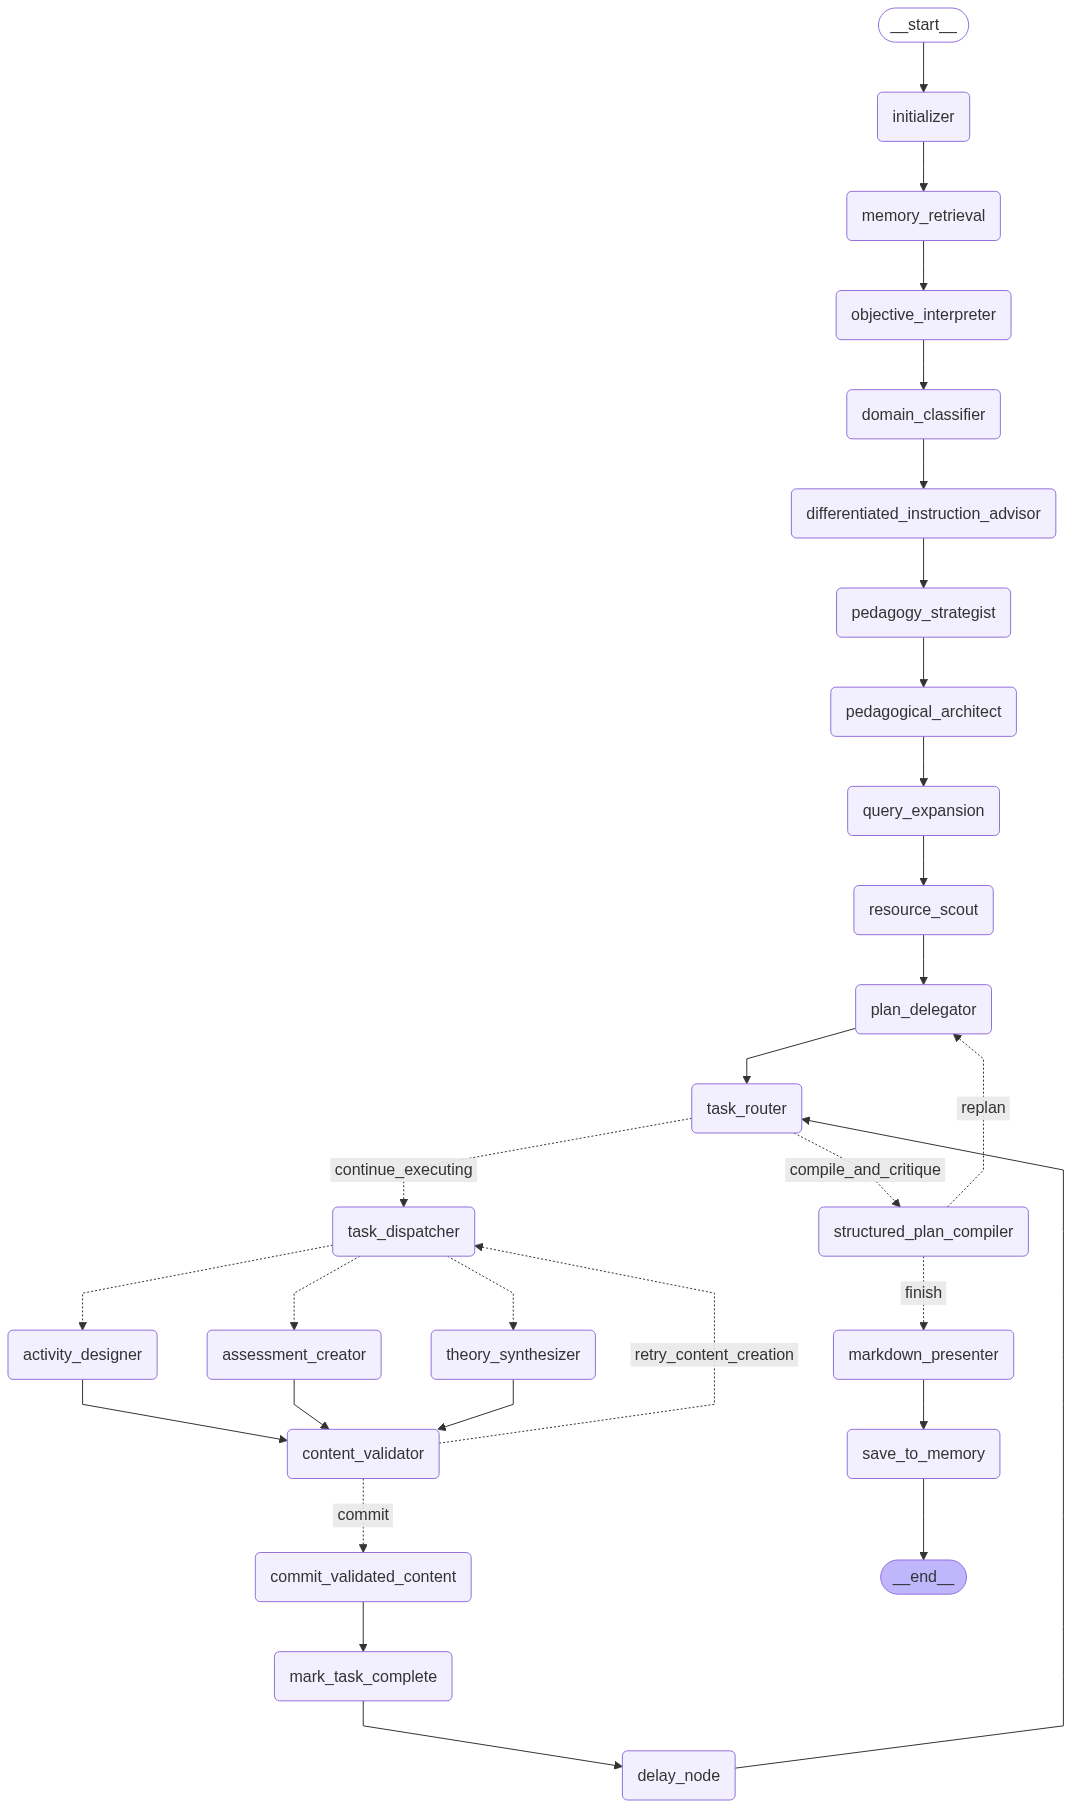

In [55]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [56]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v10.0.1 - SỬA LỖI HIỂN THỊ)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V10.0 (KỶ LUẬT THÉP) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                # <-- SỬA LỖI Ở ĐÂY: Lưu lại kết quả ngay khi nó được tạo ra
                if node_name == "markdown_presenter" and node_output.get("final_markdown_plan"):
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v10.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            # In ra trạng thái cuối cùng để gỡ lỗi nếu có vấn đề
            # last_state = # Cần một cách khác để lấy state cuối cùng nếu cần
            # pprint(last_state)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v10.0.1 - Sửa lỗi Hiển thị) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v10.0.1 - Sửa lỗi Hiển thị) đã sẵn sàng để sử dụng.


In [ ]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V10.0 (KỶ LUẬT THÉP) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và cần nhiều hoạt động tương tác cao, đa dạng để duy trì sự chú ý và hứng thú học tập.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ minh họa trực quan, cung cấp phiếu bài tập có gợi ý chi tiết và công thức, tăng cường thời gian luyện tập tại chỗ với sự hỗ trợ sát sao của giáo viên và bạn bè. Tổ chức các hoạt động nhóm nhỏ để các em dễ dàng trao đổi và nhận sự giúp đỡ.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, bài toán tổng hợp hoặc bài toán có yếu tố thực tế để các em vận dụng kiến thức một cách sáng tạo. Khuyến khích các em tự tìm tòi, chứng minh các tính chất liên quan hoặc hướng dẫn bạn bè trong nhóm. Có thể giao nhiệm vụ nhỏ về tìm hiểu ứng dụng của đường tròn ngoại tiếp/nội tiếp trong kiến trúc, kỹ thuật hoặc các bài toán liên môn.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và thụ động. Nó khuyến khích học sinh chủ động tham gia vào quá trình học tập thông qua tương tác với bạn bè. Việc làm việc nhóm giúp học sinh yếu nhận được sự hỗ trợ trực tiếp từ bạn bè và giáo viên, đồng thời học sinh khá giỏi có cơ hội củng cố kiến thức bằng cách hướng dẫn người khác. Các hoạt động đa dạng trong nhóm (thảo luận, giải bài tập, vẽ hình, trình bày) sẽ duy trì sự chú ý và hứng thú của học sinh trong suốt 90 phút. Phương pháp này cũng tạo điều kiện thuận lợi để giáo viên thực hiện chiến lược phân hóa, giao nhiệm vụ phù hợp với từng đối tượng học sinh.',
│   'key_actions': [
│   │   'Phân chia học sinh thành các nhóm nhỏ (có sự đa dạng về năng lực trong mỗi nhóm).',
│   │   'Giao các phiếu học tập hoặc nhiệm vụ cụ thể cho từng nhóm, chia nhỏ kiến thức về đường tròn ngoại tiếp và nội tiếp (định nghĩa, tính chất, cách vẽ, công thức tính bán kính).',
│   │   'Các nhóm cùng nhau thảo luận, nghiên cứu tài liệu, giải quyết các bài tập và vấn đề được giao, khuyến khích sự hỗ trợ lẫn nhau giữa các thành viên.',
│   │   'Đại diện các nhóm trình bày kết quả, cách giải quyết hoặc sản phẩm của nhóm mình trước lớp.',
│   │   'Giáo viên tổng kết, chuẩn hóa kiến thức, giải đáp thắc mắc và bổ sung những điểm còn thiếu sót.',
│   │   'Tổ chức các hoạt động luyện tập cá nhân hoặc giao bài tập về nhà có phân hóa theo năng lực học sinh.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động: "Đường tròn quanh ta": Giáo viên trình chiếu các hình ảnh/video về đường tròn trong tự nhiên, kiến trúc, kỹ thuật (ví dụ: bánh xe, đồng hồ, cầu vòm, logo). Đặt câu hỏi gợi mở về vị trí tương đối của đường tròn và các hình khác (tam giác). Tổ chức hoạt động "Ai nhanh hơn?" với các câu hỏi trắc nghiệm nhanh về đường tròn, tam giác đã học để thu hút sự chú ý và kiểm tra nhanh kiến thức cũ.',
│   'Khám phá: "Bí mật của Đường tròn Ngoại tiếp và Nội tiếp": Chia lớp thành các nhóm nhỏ (4-5 học sinh, có sự phân hóa năng lực). Phát phiếu học tập có hướng dẫn cụ thể từng bước: Phần 1 (Đường tròn ngoại tiếp): Yêu cầu học sinh vẽ một tam giác bất kỳ, sau đó tìm cách vẽ đường tròn đi qua 3 đỉnh của tam giác đó (gợi ý về đường trung trực). Thảo luận về tâm và bán kính. Phần 2 (Đường tròn nội tiếp): Yêu cầu học sinh vẽ một tam giác khác, sau đó tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của tam giác đó (gợi ý về đường phân giác). Thảo luận về tâm và bán kính. Cung cấp các công thức cơ bản liên quan. Giáo viên đi quanh các nhóm, quan sát, gợi ý, hỗ trợ trực tiếp, đảm bảo tất cả thành viên đều tham gia và hiểu bài.',
│   'Vận dụng: "Thử thách cùng Đường tròn": Các nhóm tiếp tục làm việc. Phát phiếu bài tập có phân hóa: Bài tập cơ bản (tính bán kính, xác định tâm trong các trường hợp tam giác đặc biệt như vuông, đều, cân). Bài tập vận dụng thực tế (ví dụ: một mảnh vườn hình tam giác cần xây một bể nước hình tròn lớn nhất có thể bên trong; ba ngôi làng tạo thành một tam giác, cần xây một trạm phát sóng sao cho khoảng cách đến 3 làng là như nhau). Khuyến khích các nhóm trình bày cách giải hoặc sản phẩm (ví dụ: vẽ hình minh họa). Giáo viên chọn một số bài tiêu biểu để chữa bài và chuẩn hóa kiến thức, giải đáp thắc mắc.',
│   'Củng cố và Mở rộng: "Ai là chuyên gia?": Tổ chức trò chơi "Ai là chuyên gia?" với các câu hỏi trắc nghiệm nhanh hoặc điền khuyết về định nghĩa, tính chất, công thức của đường tròn ngoại tiếp và nội tiếp. Giáo viên tổng kết lại các kiến thức cốt lõi của bài học. Giao bài tập về nhà có phân hóa (bài tập cơ bản cho học sinh yếu, bài tập nâng cao/tìm hiểu ứng dụng của đường tròn ngoại tiếp/nội tiếp trong kiến trúc, kỹ thuật hoặc các bài toán liên môn cho học sinh khá giỏi).'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp là gì',
│   'đường tròn nội tiếp là gì',
│   'công thức tính bán kính đường tròn ngoại tiếp tam giác',
│   'công thức tính bán kính đường tròn nội tiếp tam giác',
│   'tính chất đường tròn ngoại tiếp và nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp hình học',
│   'cách xác định tâm đường tròn ngoại tiếp',
│   'cách xác định tâm đường tròn nội tiếp',
│   'ứng dụng của đường tròn ngoại tiếp và nội tiếp trong toán học',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'lý thuyết đường tròn ngoại tiếp nội tiếp',
│   'các dạng bài tập đường tròn ngoại tiếp nội tiếp',
│   'mối liên hệ giữa đường tròn ngoại tiếp và nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em,\n\nVới vai trò là một giáo viên, thầy sẽ tổng hợp kiến thức cốt lõi từ các đoạn văn bản mà các em đã cung cấp về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp". Tuy nhiên, dựa trên nội dung các đoạn văn bản, thông tin chủ yếu tập trung vào vị trí tương đối của đường thẳng và đường tròn, cùng với khái niệm tiếp tuyến. Các định nghĩa cụ thể về "đường tròn ngoại tiếp" và "đường tròn nội tiếp" không được trình bày trực tiếp trong tài liệu này.\n\nDưới đây là bản tóm tắt kiến thức cốt lõi được suy luận từ các đoạn văn bản:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ CHỦ ĐỀ "Đường tròn ngoại tiếp và đường tròn nội tiếp"**\n\n*(Lưu ý: Các đoạn văn bản được cung cấp chủ yếu đề cập đến vị trí tương đối của đường thẳng và đường tròn, cùng với khái niệm tiếp tuyến.)*\n\n**1. Vị trí tương đối của đường thẳng và đường tròn**\nCho đường thẳng $a$ và đường tròn $(O; R)$, với $d$ là khoảng cách từ tâm $O$ đến đường thẳng $a$.\n*   **1.1. Cắt nhau:**\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ có đúng hai điểm chung.\n    *   Điều kiện: $d < R$.\n*   **1.2. Tiếp xúc với nhau:**\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ có đúng một điểm chung. Điểm chung này gọi là **tiếp điểm**.\n    *   Khi đó, đường thẳng $a$ được gọi là **tiếp tuyến** của đường tròn $(O; R)$ tại tiếp điểm.\n    *   Điều kiện: $d = R$.\n*   **1.3. Không giao nhau:**\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ không có điểm chung nào.\n    *   Điều kiện: $d > R$.\n\n**2. Tiếp tuyến của đường tròn**\n*   **2.1. Định nghĩa:**\n    *   Là đường thẳng chỉ có một điểm chung duy nhất với đường tròn (tiếp xúc với đường tròn).\n    *   Điểm chung đó gọi là tiếp điểm.\n*   **2.2. Dấu hiệu nhận biết tiếp tuyến (Định lí 1):**\n    *   Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó thì đường thẳng ấy là một tiếp tuyến của đường tròn.\n    *   (Suy luận từ HĐ2: Nếu đường thẳng $a$ vuông góc với bán kính $OH$ tại $H$ (là điểm trên đường tròn), thì $a$ là tiếp tuyến của đường tròn $(O; OH)$ tại $H$).\n*   **2.3. Một số tính chất liên quan đến tiếp tuyến (từ Bài tập 5.30):**\n    *   Cho đường tròn $(O)$ đường kính $AB$. Tiếp tuyến $xx\'$ tại $A$ và tiếp tuyến $yy\'$ tại $B$ của $(O)$ là các đường thẳng vuông góc với đường kính $AB$ tại $A$ và $B$ tương ứng.\n    *   Nếu một tiếp tuyến thứ ba của $(O)$ tại điểm $P$ (khác $A$ và $B$) cắt $xx\'$ tại $M$ và cắt $yy\'$ tại $N$, thì:\n        *   Độ dài đoạn $MN$ bằng tổng độ dài hai đoạn $MA$ và $NB$ ($MN = MA + NB$).\n        *   Đường thẳng đi qua $O$ và vuông góc với $AB$ cắt $MN$ tại $Q$, thì $Q$ là trung điểm của đoạn $MN$.\n\n**3. Vị trí tương đối của hai đường tròn (từ Bài tập 5.29)**\n*   Các đoạn văn bản không đưa ra định nghĩa chính thức về vị trí tương đối của hai đường tròn, nhưng có đề cập đến các trường hợp qua ví dụ:\n    *   Hai đường tròn có thể có cùng tâm (đồng tâm), như trường hợp đầu mút kim dài và kim ngắn của đồng hồ vạch nên hai đường tròn $(T_1)$ và $(T_2)$.\n    *   Hai đường tròn có thể có tâm khác nhau và bán kính khác nhau, dẫn đến các vị trí tương đối khác nhau (ví dụ đường tròn $(T_3)$ so với $(T_1)$ và $(T_2)$).\n\n---\nHy vọng bản tóm tắt này giúp các em nắm vững kiến thức từ các đoạn văn bản đã cho!'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v10.0 - Nhà hoạch định Thông thái) đang triển khai...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động: "Đường tròn quanh ta"',
│   │   'task_description': 'Giáo viên trình chiếu các hình ảnh/video về đường tròn trong tự nhiên, kiến trúc, kỹ thuật. Đặt câu hỏi gợi mở về vị trí tương đối của đường tròn và các hình khác. Tổ chức hoạt động "Ai nhanh hơn?" với các câu hỏi trắc nghiệm nhanh để thu hút sự chú ý và kiểm tra nhanh kiến thức cũ.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   │   'task_description': 'Chia lớp thành các nhóm nhỏ. Phát phiếu học tập hướng dẫn học sinh vẽ một tam giác bất kỳ, sau đó tìm cách vẽ đường tròn đi qua 3 đỉnh của tam giác đó (gợi ý về đường trung trực). Thảo luận về tâm và bán kính. Giáo viên đi quanh các nhóm, quan sát, gợi ý, hỗ trợ trực tiếp.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá: Đường tròn Nội tiếp của tam giác',
│   │   'task_description': 'Các nhóm tiếp tục hoạt động. Yêu cầu học sinh vẽ một tam giác khác, sau đó tìm cách vẽ đường tròn tiếp xúc với 3 cạnh của tam giác đó (gợi ý về đường phân giác). Thảo luận về tâm và bán kính. Cung cấp các công thức cơ bản liên quan. Giáo viên tiếp tục hỗ trợ, đảm bảo tất cả thành viên đều tham gia và hiểu bài.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng: "Thử thách cùng Đường tròn"',
│   │   'task_description': 'Các nhóm tiếp tục làm việc với phiếu bài tập có phân hóa: Bài tập cơ bản (tính bán kính, xác định tâm trong các trường hợp tam giác đặc biệt). Bài tập vận dụng thực tế. Khuyến khích các nhóm trình bày cách giải hoặc sản phẩm. Giáo viên chọn một số bài tiêu biểu để chữa bài và chuẩn hóa kiến thức, giải đáp thắc mắc.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Củng cố và Mở rộng: "Ai là chuyên gia?"',
│   │   'task_description': 'Tổ chức trò chơi "Ai là chuyên gia?" với các câu hỏi trắc nghiệm nhanh hoặc điền khuyết về định nghĩa, tính chất, công thức của đường tròn ngoại tiếp và nội tiếp. Giáo viên tổng kết lại các kiến thức cốt lõi của bài học. Giao bài tập về nhà có phân hóa.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động: "Đường tròn quanh ta"' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: "Đường tròn quanh ta"',
│   'activity_type': 'Thảo luận nhóm và chia sẻ',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   "Giới thiệu hoạt động 'Đường tròn quanh ta' và mục tiêu của buổi học.",
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát phiếu hoạt động (nếu có) hoặc hướng dẫn học sinh quan sát và ghi chép.',
│   │   "Đi lại giữa các nhóm, lắng nghe, gợi ý và hỗ trợ khi cần thiết (ví dụ: 'Các em có thấy hình tròn ở đâu nữa không?', 'Hình tròn này dùng để làm gì?').",
│   │   'Mời đại diện 2-3 nhóm lên trình bày các ví dụ và ứng dụng đã tìm được.',
│   │   'Tổng kết các ý chính, nhấn mạnh sự hiện diện và vai trò quan trọng của đường tròn trong đời sống, dẫn dắt vào bài học mới.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Quan sát các vật thể có hình dạng đường tròn trong lớp học hoặc xung quanh (ví dụ: đồng hồ, bánh xe, miệng cốc, quạt...). Thảo luận và liệt kê ít nhất 3 ví dụ về vật thể hình tròn và 1-2 ứng dụng của chúng trong đời sống. Chuẩn bị để chia sẻ trước lớp.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: 1. Tìm thêm các ví dụ về đường tròn trong tự nhiên (ví dụ: giọt nước, cầu vồng, quỹ đạo hành tinh). 2. Suy nghĩ và giải thích tại sao hình tròn lại được sử dụng phổ biến trong các ứng dụng đã nêu.',
│   'solution_guide': 'Các ví dụ về vật thể hình tròn: bánh xe, đồng hồ, đĩa CD, miệng cốc, vòng tay, quạt, ống nước, nhẫn, đồng xu... Các ứng dụng: di chuyển (bánh xe), đo thời gian (đồng hồ), trang trí, truyền tải thông tin (đĩa CD), chứa đựng (miệng cốc),... Gợi mở: Đường tròn có tính đối xứng cao, không có góc nhọn, giúp vật thể lăn dễ dàng, phân bố lực đều, tạo không gian tối ưu.',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình ảnh gợi ý về vật thể hình tròn hoặc đặt câu hỏi cụ thể hơn (ví dụ: 'Cái đồng hồ có hình gì?', 'Bánh xe dùng để làm gì?'). Có thể cho phép học sinh chỉ cần nêu ví dụ mà không cần giải thích ứng dụng.",
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các tính chất đặc biệt của đường tròn giúp nó có những ứng dụng đó (ví dụ: tính đối xứng, khả năng lăn, không có góc nhọn). Hoặc tìm các ứng dụng trong lĩnh vực khoa học, kỹ thuật phức tạp hơn.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Quan sát các vật thể có hình dạng đường tròn trong lớp học hoặc xung quanh (ví dụ: đồng hồ, bánh xe, miệng cốc, quạt...). Thảo luận và liệt kê ít nhất 3 ví dụ về vật thể hình tròn và 1-2 ứng dụng của chúng trong đời sống. Chuẩn bị để chia sẻ trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: 1. Tìm thêm các ví dụ về đường tròn trong tự nhiên (ví dụ: giọt nước, cầu vồng, quỹ đạo hành tinh). 2. Suy nghĩ và giải thích tại sao hình tròn lại được sử dụng phổ biến trong các ứng dụng đã nêu.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nhiều bước và yêu cầu học sinh thực hiện nhiều nhiệm vụ (quan sát, thảo 
luận, liệt kê ví dụ và ứng dụng, chuẩn bị trình bày, và sau đó là phần trình bày của 2-3 nhóm). Với thời lượng 15 
phút cho một hoạt động khởi động, việc hoàn thành tất cả các bước này một cách hiệu quả là rất khó khăn và dễ gây 
áp lực về thời gian cho cả giáo viên và học sinh. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước 
hơn để khớp với thời gian 15 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: "Đường tròn quanh ta"',
│   'activity_type': 'Thảo luận nhóm và chia sẻ',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động và mục tiêu khởi động.',
│   │   'Trình chiếu các hình ảnh gợi ý hoặc đưa ra các vật thể có dạng hình tròn (ví dụ: bánh xe, đồng hồ, đĩa CD, vòng tay).',
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm) và hướng dẫn nhiệm vụ thảo luận, liệt kê ví dụ trong 8 phút.',
│   │   'Đi lại các nhóm, quan sát, gợi ý và hỗ trợ khi cần, đảm bảo các nhóm đều tham gia.',
│   │   'Mời đại diện 2-3 nhóm chia sẻ nhanh các ví dụ đã liệt kê (mỗi nhóm 1-2 ví dụ) trong 5 phút.',
│   │   'Tổng hợp các ý kiến, nhấn mạnh sự phổ biến của đường tròn trong đời sống và dẫn dắt vào bài học mới trong 2 phút cuối.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 em). Quan sát các hình ảnh/vật thể có dạng hình tròn được giáo viên chuẩn bị (hoặc tự quan sát xung quanh lớp học). Thảo luận và liệt kê nhanh các vật thể, hiện tượng trong đời sống có hình dạng đường tròn hoặc liên quan đến đường tròn. Mỗi nhóm chuẩn bị 3-5 ví dụ tiêu biểu để chia sẻ nhanh trước lớp.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể suy nghĩ về các ứng dụng phức tạp hơn của đường tròn trong khoa học, công nghệ (ví dụ: quỹ đạo vệ tinh, thiết kế kiến trúc, cơ chế hoạt động của động cơ).',
│   'solution_guide': "Các ví dụ dự kiến: bánh xe, đồng hồ, đĩa CD, mặt trăng, mặt trời, vòng tay, nhẫn, ống nước, miệng cốc, vòng tròn sân bóng, quỹ đạo các hành tinh, giọt nước mưa, v.v. Giáo viên có thể đặt câu hỏi gợi mở: 'Hình tròn có vai trò gì trong các vật thể/hiện tượng này?' để kích thích tư duy.",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các gợi ý cụ thể hơn (ví dụ: 'Hãy nhìn vào đồng hồ, bánh xe, đĩa CD...'). Khuyến khích các em vẽ hoặc chỉ ra trực tiếp các vật thể có hình tròn trong lớp học.",
│   │   'for_advanced_students': "Yêu cầu các em suy nghĩ về lý do tại sao các vật thể đó lại có hình dạng đường tròn (ví dụ: 'Tại sao bánh xe lại tròn mà không phải vuông? Hình tròn mang lại lợi ích gì cho vật thể đó?')."
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 em). Quan sát các hình ảnh/vật thể có dạng hình tròn được giáo viên chuẩn bị (hoặc tự quan sát xung quanh lớp học). Thảo luận và liệt kê nhanh các vật thể, hiện tượng trong đời sống có hình dạng đường tròn hoặc liên quan đến đường tròn. Mỗi nhóm chuẩn bị 3-5 ví dụ tiêu biểu để chia sẻ nhanh trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể suy nghĩ về các ứng dụng phức tạp hơn của đường tròn trong khoa học, công nghệ (ví dụ: quỹ đạo vệ tinh, thiết kế kiến trúc, cơ chế hoạt động của động cơ).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung khá tốt và phù hợp về mặt chuyên môn. Tuy nhiên, thời lượng 15 
phút được phân bổ cho các bước trong hoạt động là không thực tế. Riêng phần thảo luận nhóm (8 phút) và chia sẻ (5 
phút) đã chiếm 13 phút, chưa kể thời gian giới thiệu, chia nhóm và tổng kết. Hoạt động này sẽ khó có thể hoàn thành
trọn vẹn trong 15 phút. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 15
phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động: "Đường tròn quanh ta"',
│   'activity_type': 'Hoạt động cá nhân/cặp đôi và chia sẻ',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động, mục tiêu và thời gian thực hiện (2 phút).',
│   │   'Phát phiếu bài tập (nếu có) hoặc hướng dẫn học sinh ghi vào vở.',
│   │   "Quan sát, đi lại trong lớp, gợi ý và hỗ trợ các học sinh gặp khó khăn (ví dụ: 'Con thử nhìn vào chiếc đồng hồ trên tường xem?', 'Cái đĩa con dùng để ăn cơm có hình gì?').",
│   │   'Mời 3-5 học sinh/cặp đôi đại diện chia sẻ nhanh các vật thể mà các em đã tìm được (5 phút).',
│   │   'Tổng kết các ý tưởng, nhấn mạnh sự phổ biến của hình tròn trong đời sống và dẫn dắt vào bài học mới về đường tròn.'
│   ],
│   'core_component': 'Học sinh quan sát xung quanh hoặc nhớ lại, sau đó liệt kê/vẽ nhanh (tối thiểu 3-5) các vật thể có hình dạng đường tròn hoặc bộ phận có hình tròn mà các em thấy trong đời sống hàng ngày (ví dụ: bánh xe, đồng hồ, đĩa CD, miệng cốc, nhẫn...). Học sinh có thể ghi vào vở hoặc phiếu bài tập cá nhân/cặp.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể: 1) Phân loại các vật thể đã liệt kê theo công dụng (ví dụ: dùng để di chuyển, dùng để chứa đựng...). 2) Vẽ thêm chi tiết cho một vật thể có hình tròn và ghi chú công dụng của nó.',
│   'solution_guide': 'Không có đáp án cố định. Mục tiêu là kích thích tư duy và nhận biết hình tròn trong thực tế. Giáo viên có thể gợi ý các vật như: bánh xe, đồng hồ, đĩa CD/DVD, miệng cốc/bát, nhẫn, vòng tay, ống nước, mặt trời, mặt trăng, quả bóng, nút áo, đồng xu, gương tròn, quạt trần, ống kính máy ảnh, v.v.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các hình ảnh gợi ý về vật thể có hình tròn hoặc chỉ yêu cầu liệt kê 2-3 vật đơn giản nhất. Giáo viên có thể đặt câu hỏi gợi mở trực tiếp cho từng học sinh.',
│   │   'for_advanced_students': "Yêu cầu học sinh giải thích ngắn gọn vai trò hoặc công dụng của hình tròn trong một số vật thể đã liệt kê (ví dụ: 'Tại sao bánh xe lại có hình tròn?'). Hoặc tìm các vật có hình tròn nhưng ít phổ biến hơn."
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh quan sát xung quanh hoặc nhớ lại, sau đó liệt kê/vẽ nhanh (tối thiểu 3-5) các vật thể có hình dạng đường tròn hoặc bộ phận có hình tròn mà các em thấy trong đời sống hàng ngày (ví dụ: bánh xe, đồng hồ, đĩa CD, miệng cốc, nhẫn...). Học sinh có thể ghi vào vở hoặc phiếu bài tập cá nhân/cặp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể: 1) Phân loại các vật thể đã liệt kê theo công dụng (ví dụ: dùng để di chuyển, dùng để chứa đựng...). 2) Vẽ thêm chi tiết cho một vật thể có hình tròn và ghi chú công dụng của nó.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này quá chi tiết và có nhiều bước, khó có thể hoàn thành trong 15 phút 
theo kế hoạch. Đặc biệt, việc học sinh liệt kê/vẽ nhanh 3-5 vật thể và sau đó 3-5 học sinh chia sẻ sẽ tốn nhiều 
thời gian hơn dự kiến cho một hoạt động khởi động. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước 
hơn để khớp với thời gian 15 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động: "Đường tròn quanh ta"',
│   'question_type': 'Tự luận',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   "Giới thiệu hoạt động 'Đường tròn quanh ta' và mục tiêu: giúp học sinh nhận biết hình dạng đường tròn trong thực tế.",
│   │   'Yêu cầu học sinh suy nghĩ và ghi nhanh tên 1-2 vật thể có hình dạng đường tròn hoặc một phần đường tròn mà các em thấy xung quanh mình (trong lớp học, ở nhà, trên đường đi học...). Ghi chú ngắn gọn về vật thể và vị trí của nó.',
│   │   'Mời 2-3 học sinh xung phong chia sẻ nhanh vật thể mà các em đã nghĩ ra. Khuyến khích các em mô tả ngắn gọn.',
│   │   'Tổng kết các ý kiến, nhấn mạnh sự hiện diện phổ biến của đường tròn trong cuộc sống và dẫn dắt vào bài học mới về đường tròn.'
│   ],
│   'core_component': 'Hãy nhanh chóng nghĩ và ghi lại tên 1-2 vật thể trong cuộc sống hàng ngày có hình dạng đường tròn hoặc một phần đường tròn. Sau đó, hãy mô tả ngắn gọn vật thể đó và vị trí của nó.',
│   'extension_component': 'Nếu còn thời gian, hãy nghĩ thêm 1-2 vật thể khác có hình dạng đường tròn hoặc một phần đường tròn mà ít người để ý đến. Giải thích tại sao bạn chọn chúng.',
│   'answer': 'Các vật thể có hình dạng đường tròn hoặc một phần đường tròn trong cuộc sống hàng ngày bao gồm: bánh xe, đồng hồ, đĩa CD, miệng cốc, vòng tay, nắp cống, mặt bàn tròn, vòng tròn trên sân bóng, v.v.',
│   'solution_guide': "Học sinh cần đưa ra các ví dụ cụ thể về vật thể có hình dạng đường tròn hoặc một phần đường tròn và mô tả ngắn gọn vị trí hoặc đặc điểm của chúng. Ví dụ: 'Bánh xe đạp - ở xe đạp', 'Mặt đồng hồ - trên tường lớp học', 'Vòng tay - trên cổ tay'.",
│   'differentiation': {
│   │   'for_struggling_students': 'Nếu học sinh gặp khó khăn, giáo viên có thể gợi ý các vật thể quen thuộc như bánh xe, đồng hồ, đĩa CD, miệng cốc, hoặc vòng tay.',
│   │   'for_advanced_students': 'Yêu cầu học sinh suy nghĩ về các vật thể có hình dạng đường tròn nhưng ít rõ ràng hơn (ví dụ: quỹ đạo của hành tinh, sóng nước lan tỏa, tiết diện của một ống nước) hoặc giải thích ngắn gọn vai trò của hình tròn trong vật thể đó.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHãy nhanh chóng nghĩ và ghi lại tên 1-2 vật thể trong cuộc sống hàng ngày có hình dạng đường tròn hoặc một phần đường tròn. Sau đó, hãy mô tả ngắn gọn vật thể đó và vị trí của nó.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, hãy nghĩ thêm 1-2 vật thể khác có hình dạng đường tròn hoặc một phần đường tròn mà ít người để ý đến. Giải thích tại sao bạn chọn chúng.'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá: Đường tròn Ngoại tiếp của tam giác' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu của hoạt động.',
│   │   'Phát phiếu học tập, thước, compa (hoặc hướng dẫn sử dụng phần mềm hình học).',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân để hỗ trợ, gợi ý khi học sinh gặp khó khăn (ví dụ: cách vẽ đường trung trực).',
│   │   'Yêu cầu một vài học sinh/nhóm chia sẻ kết quả và nhận xét của mình.',
│   │   'Tổng kết, chốt kiến thức về định nghĩa, tính chất của đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': 'Học sinh thực hiện các bước sau trên giấy/phần mềm hình học:\n1. Vẽ một tam giác ABC bất kỳ.\n2. Vẽ đường trung trực của hai cạnh bất kỳ của tam giác (ví dụ: cạnh AB và BC).\n3. Xác định giao điểm của hai đường trung trực vừa vẽ. Đặt tên giao điểm đó là O.\n4. Dùng compa (hoặc công cụ vẽ đường tròn) vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC).\n5. Quan sát và ghi nhận kết quả: Đường tròn này đi qua những điểm nào của tam giác?',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1. Thử vẽ đường tròn ngoại tiếp cho một tam giác vuông, một tam giác cân, một tam giác đều và rút ra nhận xét về vị trí của tâm đường tròn ngoại tiếp trong từng trường hợp.\n2. Thảo luận nhóm về mối liên hệ giữa các đường trung trực và tâm đường tròn ngoại tiếp.',
│   'solution_guide': "Gợi ý cho học sinh khi gặp khó khăn:\n- 'Đường trung trực của một đoạn thẳng là gì? Nó có tính chất gì đặc biệt?'\n- 'Giao điểm của các đường trung trực có mối liên hệ gì với các đỉnh của tam giác?'\n- 'Khoảng cách từ tâm O đến các đỉnh A, B, C có bằng nhau không? Tại sao?'\n- Chốt kiến thức: Giao điểm của ba đường trung trực của một tam giác là tâm của đường tròn đi qua ba đỉnh của tam giác đó (đường tròn ngoại tiếp).",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn hình tam giác hoặc hướng dẫn từng bước cụ thể cách vẽ đường trung trực. Giáo viên có thể gợi ý kiểm tra lại bằng cách đo khoảng cách từ tâm O đến các đỉnh A, B, C.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử vẽ đường trung trực của cạnh còn lại (cạnh AC) và nhận xét về vị trí của nó. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác cân, tam giác đều) và rút ra nhận xét về vị trí tâm O trong từng trường hợp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh thực hiện các bước sau trên giấy/phần mềm hình học:\n1. Vẽ một tam giác ABC bất kỳ.\n2. Vẽ đường trung trực của hai cạnh bất kỳ của tam giác (ví dụ: cạnh AB và BC).\n3. Xác định giao điểm của hai đường trung trực vừa vẽ. Đặt tên giao điểm đó là O.\n4. Dùng compa (hoặc công cụ vẽ đường tròn) vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC).\n5. Quan sát và ghi nhận kết quả: Đường tròn này đi qua những điểm nào của tam giác?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1. Thử vẽ đường tròn ngoại tiếp cho một tam giác vuông, một tam giác cân, một tam giác đều và rút ra nhận xét về vị trí của tâm đường tròn ngoại tiếp trong từng trường hợp.\n2. Thảo luận nhóm về mối liên hệ giữa các đường trung trực và tâm đường tròn ngoại tiếp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có vẻ quá chi tiết và nhiều bước để hoàn thành một cách hiệu quả trong 25 
phút. Việc vẽ đường trung trực chính xác và sau đó vẽ đường tròn ngoại tiếp đòi hỏi thời gian và sự tỉ mỉ của học 
sinh, đặc biệt là khi có cả phần giới thiệu, hỗ trợ, chia sẻ và tổng kết của giáo viên. Phần mở rộng cũng cho thấy 
nội dung cốt lõi đã khá đầy đủ. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời
gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm nhỏ/cá nhân',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học: "Hôm nay chúng ta sẽ cùng khám phá một loại đường tròn đặc biệt liên quan đến tam giác."',
│   │   'Phát giấy, thước, compa cho học sinh (nếu chưa có).',
│   │   'Hướng dẫn học sinh thực hiện các bước trong phần cốt lõi.',
│   │   'Quan sát, đi lại hỗ trợ các nhóm/cá nhân gặp khó khăn, gợi ý khi cần.',
│   │   'Yêu cầu một vài nhóm/cá nhân chia sẻ kết quả và nhận xét.',
│   │   'Tổng kết, chốt kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.'
│   ],
│   'core_component': 'Mỗi học sinh/nhóm nhỏ thực hiện các bước sau trên giấy:\n1.  Vẽ một tam giác ABC bất kỳ (không phải tam giác đặc biệt như đều, vuông cân).\n2.  Vẽ đường trung trực của cạnh AB.\n3.  Vẽ đường trung trực của cạnh BC.\n4.  Xác định giao điểm O của hai đường trung trực vừa vẽ.\n5.  Dùng compa, đặt tâm tại O và vẽ đường tròn đi qua đỉnh A.\n6.  Quan sát xem đường tròn này có đi qua hai đỉnh B và C còn lại không? Ghi lại nhận xét của em.',
│   'extension_component': 'Nếu còn thời gian:\n1.  Thử vẽ đường trung trực của cạnh AC và nhận xét về vị trí của nó so với điểm O.\n2.  Thảo luận: Tại sao điểm O lại cách đều ba đỉnh của tam giác?',
│   'solution_guide': 'Gợi ý/Câu hỏi gợi mở:\n*   Giao điểm O của hai đường trung trực sẽ cách đều ba đỉnh A, B, C của tam giác.\n*   Đường tròn vẽ được sẽ đi qua cả ba đỉnh của tam giác.\n*   Vị trí của tâm O:\n    *   Tam giác nhọn: O nằm bên trong tam giác.\n    *   Tam giác vuông: O nằm trên trung điểm cạnh huyền.\n    *   Tam giác tù: O nằm bên ngoài tam giác.\n*   Lý do O cách đều 3 đỉnh: Mọi điểm trên đường trung trực của một đoạn thẳng đều cách đều hai mút của đoạn thẳng đó. O nằm trên đường trung trực của AB nên OA=OB. O nằm trên đường trung trực của BC nên OB=OC. Suy ra OA=OB=OC.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp tam giác đã vẽ sẵn hoặc hướng dẫn từng bước vẽ đường trung trực (nhắc lại cách vẽ). Tập trung vào việc vẽ đúng 2 đường trung trực và tìm giao điểm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử với các loại tam giác khác nhau (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp. Hoặc yêu cầu chứng minh ngắn gọn tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nMỗi học sinh/nhóm nhỏ thực hiện các bước sau trên giấy:\n1.  Vẽ một tam giác ABC bất kỳ (không phải tam giác đặc biệt như đều, vuông cân).\n2.  Vẽ đường trung trực của cạnh AB.\n3.  Vẽ đường trung trực của cạnh BC.\n4.  Xác định giao điểm O của hai đường trung trực vừa vẽ.\n5.  Dùng compa, đặt tâm tại O và vẽ đường tròn đi qua đỉnh A.\n6.  Quan sát xem đường tròn này có đi qua hai đỉnh B và C còn lại không? Ghi lại nhận xét của em.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian:\n1.  Thử vẽ đường trung trực của cạnh AC và nhận xét về vị trí của nó so với điểm O.\n2.  Thảo luận: Tại sao điểm O lại cách đều ba đỉnh của tam giác?'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp. Tuy nhiên, với 6 bước thực hành 
cốt lõi yêu cầu vẽ hình chính xác (vẽ tam giác, vẽ 2 đường trung trực, xác định giao điểm, vẽ đường tròn) cùng với 
thời gian giới thiệu, hỗ trợ học sinh và tổng kết, 25 phút là không đủ để học sinh có thể hoàn thành một cách hiệu 
quả và giáo viên có thể chốt kiến thức. Hoạt động này có thể cần 35-45 phút để thực hiện đầy đủ. Hãy thiết kế lại 
một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và thảo luận nhóm nhỏ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học và hướng dẫn các bước thực hiện hoạt động.',
│   │   'Phát phiếu học tập (nếu có) hoặc hướng dẫn học sinh vẽ tam giác.',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân để hỗ trợ, giải đáp thắc mắc và đảm bảo học sinh thực hiện đúng các bước vẽ đường trung trực và sử dụng compa.',
│   │   'Gợi ý các câu hỏi để học sinh tự khám phá tính chất của tâm đường tròn ngoại tiếp.',
│   │   'Tổ chức phần thảo luận và tổng kết kiến thức, chốt lại định nghĩa và tính chất của tâm đường tròn ngoại tiếp và đường tròn ngoại tiếp.'
│   ],
│   'core_component': 'Học sinh thực hiện các bước sau trên phiếu học tập (hoặc vở):\n1.  **Vẽ/Quan sát tam giác (5 phút):** Vẽ một tam giác nhọn bất kỳ (hoặc sử dụng tam giác đã được in sẵn trên phiếu học tập).\n2.  **Vẽ hai đường trung trực (7 phút):** Chọn hai cạnh bất kỳ của tam giác và vẽ hai đường trung trực tương ứng của chúng. Xác định giao điểm của hai đường trung trực này.\n3.  **Kiểm tra và vẽ đường tròn (8 phút):** Dùng compa kiểm tra xem giao điểm vừa tìm được có cách đều ba đỉnh của tam giác hay không. Nếu có, dùng compa vẽ đường tròn đi qua ba đỉnh của tam giác với tâm là giao điểm đó.\n4.  **Thảo luận và ghi nhận (5 phút):** Thảo luận nhóm nhỏ (2-3 phút) và chia sẻ nhanh (2 phút) về:\n    *   Điểm giao của hai đường trung trực có tính chất gì đặc biệt?\n    *   Đường tròn vừa vẽ được gọi là gì?\n    *   Vị trí của tâm đường tròn này đối với tam giác nhọn?',
│   'extension_component': 'Nếu hoàn thành sớm, học sinh có thể:\n*   Lặp lại quy trình với một tam giác vuông hoặc tam giác tù để quan sát vị trí của tâm đường tròn ngoại tiếp.\n*   Thử vẽ đường trung trực thứ ba của tam giác và kiểm tra xem nó có đi qua giao điểm của hai đường trung trực kia không.',
│   'solution_guide': 'Gợi ý giải và các câu hỏi gợi mở:\n*   **Kiểm tra:** Đảm bảo học sinh vẽ đường trung trực chính xác (vuông góc với cạnh và đi qua trung điểm của cạnh đó).\n*   **Gợi mở:**\n    *   Mọi điểm nằm trên đường trung trực của một đoạn thẳng có tính chất gì?\n    *   Tại sao điểm giao của hai đường trung trực lại cách đều ba đỉnh của tam giác?\n    *   Nếu vẽ đường trung trực thứ ba, nó sẽ đi qua đâu so với hai đường trung trực kia?\n    *   Tâm đường tròn ngoại tiếp nằm ở đâu đối với tam giác nhọn, vuông, tù?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn tam giác và các điểm trung điểm của cạnh để học sinh chỉ cần vẽ đường vuông góc. Hướng dẫn từng bước một, có thể làm mẫu một phần nhỏ. Khuyến khích làm việc theo cặp để hỗ trợ lẫn nhau.',
│   │   'for_advanced_students': 'Yêu cầu học sinh lặp lại quy trình với một tam giác vuông và một tam giác tù để quan sát và so sánh vị trí của tâm đường tròn ngoại tiếp. Thử thách học sinh giải thích tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh thực hiện các bước sau trên phiếu học tập (hoặc vở):\n1.  **Vẽ/Quan sát tam giác (5 phút):** Vẽ một tam giác nhọn bất kỳ (hoặc sử dụng tam giác đã được in sẵn trên phiếu học tập).\n2.  **Vẽ hai đường trung trực (7 phút):** Chọn hai cạnh bất kỳ của tam giác và vẽ hai đường trung trực tương ứng của chúng. Xác định giao điểm của hai đường trung trực này.\n3.  **Kiểm tra và vẽ đường tròn (8 phút):** Dùng compa kiểm tra xem giao điểm vừa tìm được có cách đều ba đỉnh của tam giác hay không. Nếu có, dùng compa vẽ đường tròn đi qua ba đỉnh của tam giác với tâm là giao điểm đó.\n4.  **Thảo luận và ghi nhận (5 phút):** Thảo luận nhóm nhỏ (2-3 phút) và chia sẻ nhanh (2 phút) về:\n    *   Điểm giao của hai đường trung trực có tính chất gì đặc biệt?\n    *   Đường tròn vừa vẽ được gọi là gì?\n    *   Vị trí của tâm đường tròn này đối với tam giác nhọn?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNế

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn và sư phạm tốt. Tuy nhiên, thời lượng 25 phút là không
đủ để hoàn thành toàn bộ hoạt động một cách hiệu quả. Mặc dù các bước của học sinh cộng lại là 25 phút, nhưng thời 
gian thực tế cần có cho việc giới thiệu của giáo viên, phát tài liệu, hướng dẫn chi tiết, thời gian học sinh thực 
hành vẽ hình (đặc biệt là vẽ đường trung trực và sử dụng compa chính xác thường tốn nhiều thời gian hơn dự kiến), 
và phần tổng kết, chốt kiến thức của giáo viên sẽ vượt quá đáng kể. Việc vẽ hình chính xác trong hình học thường 
đòi hỏi sự tỉ mỉ và thời gian, đặc biệt với học sinh chưa quen. Hãy thiết kế lại một phiên bản hoạt động đơn giản 
hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và thảo luận nhóm nhỏ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động: Khám phá tâm và bán kính của đường tròn đi qua ba đỉnh của tam giác.',
│   │   'Phát giấy, thước, compa cho học sinh (nếu cần).',
│   │   'Hướng dẫn học sinh các bước thực hiện phần cốt lõi, nhấn mạnh sự chính xác khi vẽ đường trung trực và sử dụng compa.',
│   │   'Đi lại các nhóm/cá nhân, quan sát, hỗ trợ kịp thời các học sinh gặp khó khăn trong việc vẽ hình hoặc xác định giao điểm.',
│   │   "Gợi ý, đặt câu hỏi mở để học sinh tự rút ra kết luận (ví dụ: 'Em thấy điểm này có gì đặc biệt với ba đỉnh của tam giác?').",
│   │   'Tổng kết hoạt động, chốt kiến thức về định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và tính chất của nó (giao điểm của ba đường trung trực).',
│   │   'Giao nhiệm vụ cho phần mở rộng (nếu có thời gian).'
│   ],
│   'core_component': 'Học sinh thực hiện các bước sau trên giấy:\n1. Vẽ một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Vẽ đường trung trực của cạnh AB và cạnh BC. (Lưu ý: Chỉ cần vẽ 2 đường trung trực).\n3. Xác định giao điểm O của hai đường trung trực vừa vẽ.\n4. Dùng compa kiểm tra khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Ghi lại nhận xét của em.\n5. Thảo luận nhanh với bạn bên cạnh: Từ kết quả kiểm tra, em có nhận xét gì về điểm O? Nó có thể là tâm của đường tròn nào đi qua ba đỉnh của tam giác?',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1. Vẽ thêm đường trung trực của cạnh AC. Quan sát xem đường trung trực thứ ba này có đi qua điểm O hay không.\n2. Thử vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát xem đường tròn này có đi qua cả ba đỉnh của tam giác hay không.\n3. Thử vẽ lại với một loại tam giác khác (ví dụ: tam giác vuông hoặc tam giác tù) và quan sát vị trí của tâm O.',
│   'solution_guide': 'Gợi ý giải: Giao điểm O của hai đường trung trực sẽ cách đều ba đỉnh A, B, C của tam giác. Do đó, O là tâm của đường tròn đi qua ba đỉnh A, B, C (đường tròn ngoại tiếp tam giác).\nCâu hỏi gợi mở:\n- Tại sao chỉ cần vẽ hai đường trung trực mà không cần ba?\n- Nếu điểm O cách đều A và B, và cách đều B và C, thì nó có cách đều A và C không? Tại sao?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã được vẽ sẵn trên giấy. Hướng dẫn từng bước cụ thể cách vẽ đường trung trực (gấp giấy hoặc dùng thước, compa). Có thể chỉ yêu cầu kiểm tra khoảng cách từ O đến 2 đỉnh trước, sau đó mới đến đỉnh thứ 3.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích/chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác. Gợi ý liên hệ đến tính chất của đường trung trực (tập hợp các điểm cách đều hai mút đoạn thẳng). Yêu cầu dự đoán và kiểm tra vị trí tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh thực hiện các bước sau trên giấy:\n1. Vẽ một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Vẽ đường trung trực của cạnh AB và cạnh BC. (Lưu ý: Chỉ cần vẽ 2 đường trung trực).\n3. Xác định giao điểm O của hai đường trung trực vừa vẽ.\n4. Dùng compa kiểm tra khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Ghi lại nhận xét của em.\n5. Thảo luận nhanh với bạn bên cạnh: Từ kết quả kiểm tra, em có nhận xét gì về điểm O? Nó có thể là tâm của đường tròn nào đi qua ba đỉnh của tam giác?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1. Vẽ thêm đường trung trực của cạnh AC. Quan sát xem đường trung trực thứ ba này có đi qua điểm O hay không.\n2. Thử vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát xem đường tròn này có đi qua cả ba đỉnh của tam giác hay không.\n3. Thử vẽ lại với một loại tam giác khác (ví dụ: tam giác vuông hoặc tam giác tù) và quan sát vị trí của tâm O.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp. Tuy nhiên, thời lượng 25 phút là
quá ngắn để học sinh có thể hoàn thành đầy đủ các bước thực hành vẽ hình (đặc biệt là vẽ đường trung trực một cách 
chính xác) và thảo luận, cũng như để giáo viên tổng kết kiến thức một cách hiệu quả. Quá trình khám phá và thực 
hành cần nhiều thời gian hơn để đảm bảo học sinh nắm vững kiến thức. Hãy thiết kế lại một phiên bản hoạt động đơn 
giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thảo luận nhóm nhỏ và thực hành cá nhân',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và phân chia thời gian cho từng phần hoạt động.',
│   │   'Hướng dẫn học sinh ôn tập nhanh về cách vẽ và tính chất của đường trung trực của đoạn thẳng (có thể vẽ mẫu nhanh một đường trung trực trên bảng).',
│   │   'Phát phiếu học tập có sẵn các loại tam giác (nhọn, vuông, tù) cho từng nhóm học sinh.',
│   │   'Quan sát, đi lại giữa các nhóm, hỗ trợ và giải đáp thắc mắc khi học sinh thực hành vẽ đường trung trực và đường tròn.',
│   │   "Gợi ý các câu hỏi để học sinh tự khám phá và thảo luận trong nhóm (ví dụ: 'Điểm O có đặc điểm gì?', 'Đường tròn này có đi qua tất cả các đỉnh không?').",
│   │   'Tổ chức cho các nhóm đại diện chia sẻ kết quả và nhận xét của mình.',
│   │   'Tổng kết, chốt kiến thức về định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và tính chất của nó (là giao điểm của ba đường trung trực).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm nhỏ (2-3 người) với phiếu học tập có sẵn các tam giác (nhọn, vuông, tù):\n1.  **Ôn tập và Chuẩn bị (5 phút):** Giáo viên hướng dẫn học sinh nhắc lại cách vẽ đường trung trực của một đoạn thẳng và nêu tính chất của các điểm nằm trên đường trung trực.\n2.  **Thực hành Khám phá (15 phút):**\n    *   Mỗi nhóm chọn một tam giác bất kỳ trên phiếu học tập.\n    *   Vẽ đường trung trực của hai cạnh bất kỳ của tam giác đó (ví dụ: cạnh AB và BC).\n    *   Xác định giao điểm của hai đường trung trực vừa vẽ (gọi là điểm O).\n    *   Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC).\n    *   Quan sát và thảo luận trong nhóm: Đường tròn này có đi qua cả ba đỉnh của tam giác không? Điểm O có mối liên hệ gì với các đỉnh của tam giác?\n3.  **Báo cáo và Tổng kết nhanh (5 phút):** Đại diện 1-2 nhóm trình bày kết quả và nhận xét của mình. Giáo viên tổng kết, chốt kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1.  Vẽ đường trung trực thứ ba của tam giác đã chọn và kiểm tra xem nó có đi qua điểm O hay không.\n2.  Thực hiện lại các bước khám phá với một loại tam giác khác (ví dụ: nếu ban đầu chọn tam giác nhọn, giờ thử với tam giác vuông hoặc tù) để quan sát vị trí của tâm O.',
│   'solution_guide': 'Gợi ý các câu hỏi để học sinh tự khám phá:\n*   Điểm O là giao điểm của hai đường trung trực, vậy O cách đều những điểm nào?\n*   Nếu O cách đều A và B (OA=OB), và O cách đều B và C (OB=OC), thì OA, OB, OC có bằng nhau không? Điều này có ý nghĩa gì khi vẽ đường tròn tâm O?\n*   Vị trí của tâm O thay đổi như thế nào đối với tam giác nhọn, vuông, tù?\n\n**Kiến thức cần chốt:**\n*   Giao điểm của hai đường trung trực của hai cạnh trong tam giác cách đều ba đỉnh của tam giác đó.\n*   Điểm đó là tâm của đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp tam giác).\n*   Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác có kích thước lớn hơn, dễ vẽ hơn (ví dụ: tam giác cân, tam giác đều). Hướng dẫn từng bước cụ thể hơn, có thể vẽ mẫu một đường trung trực trên bảng để học sinh làm theo. Gợi ý trực tiếp về tính chất của đường trung trực để học sinh dễ dàng suy luận.',
│   │   'for_advanced_students': "Yêu cầu học sinh dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (nhọn, vuông, tù). Đặt câu hỏi nâng cao: 'Tại sao ba đường trung trực của một tam giác lại đồng quy?' hoặc 'Có phải mọi tam giác đều có đường tròn ngoại tiếp không?'"
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm nhỏ (2-3 người) với phiếu học tập có sẵn các tam giác (nhọn, vuông, tù):\n1.  **Ôn tập và Chuẩn bị (5 phút):** Giáo viên hướng dẫn học sinh nhắc lại cách vẽ đường trung trực của một đoạn thẳng và nêu tính

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này quá chi tiết và có nhiều bước, khó có thể hoàn thành trong 25 phút đã
cho. Cụ thể, phần "Thực hành Khám phá" yêu cầu học sinh vẽ hai đường trung trực và đường tròn một cách chính xác, 
sau đó thảo luận, điều này thường tốn nhiều thời gian hơn 15 phút đối với đa số học sinh. Phần "Báo cáo và Tổng kết
nhanh" với chỉ 5 phút là không đủ để 1-2 nhóm trình bày và giáo viên tổng kết, chốt kiến thức một cách hiệu quả và 
sâu sắc. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm nhỏ và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát giấy, compa, thước cho các nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động cốt lõi.',
│   │   'Đi vòng quanh các nhóm, quan sát, hỗ trợ kịp thời các nhóm gặp khó khăn trong việc vẽ hoặc đo đạc.',
│   │   "Gợi ý, đặt câu hỏi dẫn dắt để học sinh tự khám phá mối liên hệ (ví dụ: 'Các khoảng cách đó có gì đặc biệt?', 'Đường tròn này đi qua những điểm nào?').",
│   │   'Tổ chức cho 1-2 nhóm trình bày nhanh kết quả và nhận xét của mình (khoảng 4 phút).',
│   │   "Tổng kết, chốt kiến thức về khái niệm 'đường trung trực của tam giác', 'tâm đường tròn ngoại tiếp', 'đường tròn ngoại tiếp' và tính chất của nó (khoảng 6 phút)."
│   ],
│   'core_component': "Trong 15 phút, các nhóm thực hiện các bước sau:\n1. Mỗi nhóm vẽ một tam giác ABC bất kỳ (không phải tam giác đặc biệt như đều, vuông cân) lên giấy A4.\n2. Vẽ đường trung trực của cạnh AB và cạnh BC. Gọi giao điểm của hai đường trung trực này là điểm O.\n3. Đo khoảng cách từ điểm O đến các đỉnh A, B, C. Nêu nhận xét về các khoảng cách này.\n4. Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát đường tròn này đi qua những điểm nào của tam giác.\n5. Thảo luận nhanh trong nhóm: 'Điểm O có vai trò gì đặc biệt đối với tam giác ABC và đường tròn vừa vẽ?'",
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường trung trực thứ ba của cạnh AC và kiểm tra xem nó có đi qua điểm O hay không. Hoặc thử vẽ đường tròn ngoại tiếp cho một tam giác khác có hình dạng đặc biệt (ví dụ: tam giác vuông, tam giác tù).',
│   'solution_guide': '1. Học sinh sẽ nhận thấy khoảng cách từ O đến A, B, C là bằng nhau.\n2. Đường tròn tâm O, bán kính OA sẽ đi qua cả ba đỉnh A, B, C của tam giác.\n3. Giao điểm của hai đường trung trực của hai cạnh trong tam giác cách đều ba đỉnh của tam giác đó. Điểm này chính là tâm của đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp). Đường tròn đó được gọi là đường tròn ngoại tiếp tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn hoặc hướng dẫn từng bước cụ thể hơn trong việc vẽ đường trung trực. Có thể chỉ yêu cầu vẽ 1 đường trung trực và giáo viên gợi ý bước tiếp theo để tìm giao điểm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử chứng minh tại sao điểm O lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (vuông, tù, đều) và nhận xét vị trí tâm O.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nTrong 15 phút, các nhóm thực hiện các bước sau:\n1. Mỗi nhóm vẽ một tam giác ABC bất kỳ (không phải tam giác đặc biệt như đều, vuông cân) lên giấy A4.\n2. Vẽ đường trung trực của cạnh AB và cạnh BC. Gọi giao điểm của hai đường trung trực này là điểm O.\n3. Đo khoảng cách từ điểm O đến các đỉnh A, B, C. Nêu nhận xét về các khoảng cách này.\n4. Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát đường tròn này đi qua những điểm nào của tam giác.\n5. Thảo luận nhanh trong nhóm: 'Điểm O có vai trò gì đặc biệt đối với tam giác ABC và đường tròn vừa vẽ?'\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể thử vẽ đường trung trực thứ ba của cạnh AC và kiểm tra xem nó có đi qua điểm O hay không. Hoặc thử vẽ đường tròn ngoại tiếp cho một tam giác khác có hình dạng đặc biệt (ví dụ: tam giác vuông, tam giác tù)."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này có vẻ quá nhiều bước và chi tiết cho thời lượng 25 phút. Việc vẽ hai
đường trung trực một cách chính xác, đo đạc, vẽ đường tròn, và sau đó còn có thời gian cho trình bày của nhóm và 
tổng kết của giáo viên sẽ rất khó để hoàn thành trong 25 phút. Hoạt động này có thể cần ít nhất 35-40 phút để đảm 
bảo học sinh có đủ thời gian khám phá và giáo viên có thể chốt kiến thức hiệu quả. Hãy thiết kế lại một phiên bản 
hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập và dụng cụ (thước, compa) cho các nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động cốt lõi.',
│   │   'Quan sát, đi lại giữa các nhóm để hỗ trợ, gợi ý khi học sinh gặp khó khăn trong việc vẽ đường trung trực hoặc sử dụng compa.',
│   │   'Yêu cầu các nhóm trình bày nhanh kết quả và kết luận của mình (nếu còn thời gian).',
│   │   'Tổng kết kiến thức trọng tâm: Khẳng định giao điểm của các đường trung trực là tâm đường tròn ngoại tiếp và đường tròn này đi qua ba đỉnh của tam giác.'
│   ],
│   'core_component': 'Mỗi nhóm vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn). 1. Vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác. 2. Xác định giao điểm của hai đường trung trực này (gọi là điểm O). 3. Dùng compa, đặt mũi nhọn tại O và đầu chì tại một đỉnh của tam giác. Vẽ đường tròn. 4. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại không. 5. Thảo luận trong nhóm và rút ra kết luận về điểm O và đường tròn vừa vẽ.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp cho một tam giác vuông hoặc tam giác tù và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong các trường hợp này.',
│   'solution_guide': 'Gợi ý giải: Giao điểm của hai (hoặc ba) đường trung trực của tam giác chính là tâm của đường tròn ngoại tiếp tam giác. Khoảng cách từ tâm này đến ba đỉnh của tam giác là bằng nhau (chính là bán kính của đường tròn ngoại tiếp). Đường tròn ngoại tiếp là đường tròn đi qua cả ba đỉnh của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp tam giác đã vẽ sẵn trên giấy hoặc hướng dẫn từng bước cụ thể hơn trong việc vẽ đường trung trực. Nhấn mạnh việc kiểm tra bằng compa để đảm bảo đường tròn đi qua ba đỉnh.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử với các loại tam giác khác nhau (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp so với tam giác trong từng trường hợp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nMỗi nhóm vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn). 1. Vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác. 2. Xác định giao điểm của hai đường trung trực này (gọi là điểm O). 3. Dùng compa, đặt mũi nhọn tại O và đầu chì tại một đỉnh của tam giác. Vẽ đường tròn. 4. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại không. 5. Thảo luận trong nhóm và rút ra kết luận về điểm O và đường tròn vừa vẽ.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp cho một tam giác vuông hoặc tam giác tù và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong các trường hợp này.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này quá chi tiết và có nhiều bước thực hành đòi hỏi sự tỉ mỉ, đặc biệt là
việc vẽ hai đường trung trực và đường tròn ngoại tiếp. Với thời lượng 25 phút, học sinh sẽ khó có thể hoàn thành 
đầy đủ các bước từ vẽ tam giác, vẽ hai đường trung trực, xác định tâm, vẽ đường tròn, đến thảo luận nhóm và giáo 
viên tổng kết kiến thức trọng tâm một cách hiệu quả. Hoạt động này có thể cần ít nhất 35-40 phút để đảm bảo chất 
lượng. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành và Thảo luận nhóm',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập có sẵn tam giác hoặc yêu cầu học sinh vẽ nhanh một tam giác bất kỳ.',
│   │   'Hướng dẫn học sinh vẽ đường trung trực của một cạnh tam giác.',
│   │   'Chiếu hình ảnh hoặc cung cấp hình vẽ có sẵn tam giác với ba đường trung trực và giao điểm đã được đánh dấu.',
│   │   'Yêu cầu học sinh đo khoảng cách từ giao điểm đến các đỉnh và thảo luận nhóm về nhận xét.',
│   │   'Lắng nghe, gợi mở và hỗ trợ các nhóm trong quá trình thảo luận.',
│   │   'Tổng kết kiến thức trọng tâm về tâm đường tròn ngoại tiếp, đường tròn ngoại tiếp và tính chất của giao điểm ba đường trung trực.',
│   │   'Yêu cầu học sinh ghi chép.'
│   ],
│   'core_component': 'Học sinh (HS) vẽ nhanh một tam giác bất kỳ (hoặc sử dụng tam giác cho sẵn trên phiếu bài tập). HS vẽ đường trung trực của MỘT cạnh tam giác. Giáo viên (GV) chiếu hình ảnh hoặc cung cấp hình vẽ có sẵn một tam giác với BA đường trung trực đã được vẽ và giao điểm O được đánh dấu. HS quan sát hình vẽ, dùng thước đo khoảng cách từ O đến các đỉnh của tam giác. HS thảo luận nhóm nhỏ (2-3 phút) về nhận xét khoảng cách từ O đến các đỉnh và khả năng vẽ đường tròn đi qua ba đỉnh. GV tổng kết, giới thiệu khái niệm tâm đường tròn ngoại tiếp và đường tròn ngoại tiếp, yêu cầu HS ghi nhớ tính chất.',
│   'extension_component': 'HS tìm hiểu vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù). HS thử chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.',
│   'solution_guide': 'Gợi ý: Giao điểm của ba đường trung trực của tam giác cách đều ba đỉnh của tam giác. Điểm đó là tâm của đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp). Đường tròn này được gọi là đường tròn ngoại tiếp tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu bài tập có sẵn tam giác và đường trung trực mẫu. Hướng dẫn từng bước cụ thể việc đo khoảng cách. Tập trung vào việc nhận biết tính chất cách đều.',
│   │   'for_advanced_students': 'Yêu cầu HS giải thích tại sao ba đường trung trực lại đồng quy tại một điểm. Thử thách HS vẽ đường tròn ngoại tiếp cho một tam giác vuông và nhận xét vị trí tâm.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh (HS) vẽ nhanh một tam giác bất kỳ (hoặc sử dụng tam giác cho sẵn trên phiếu bài tập). HS vẽ đường trung trực của MỘT cạnh tam giác. Giáo viên (GV) chiếu hình ảnh hoặc cung cấp hình vẽ có sẵn một tam giác với BA đường trung trực đã được vẽ và giao điểm O được đánh dấu. HS quan sát hình vẽ, dùng thước đo khoảng cách từ O đến các đỉnh của tam giác. HS thảo luận nhóm nhỏ (2-3 phút) về nhận xét khoảng cách từ O đến các đỉnh và khả năng vẽ đường tròn đi qua ba đỉnh. GV tổng kết, giới thiệu khái niệm tâm đường tròn ngoại tiếp và đường tròn ngoại tiếp, yêu cầu HS ghi nhớ tính chất.\n\n**Phần Mở rộng (nếu còn thời gian):**\nHS tìm hiểu vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù). HS thử chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm. Tuy nhiên, với thời lượng 25 phút,
các bước như học sinh tự vẽ đường trung trực (dù chỉ một cạnh), đo đạc, và đặc biệt là phần tổng kết kiến thức 
trọng tâm cùng với việc ghi chép sẽ rất khó để hoàn thành một cách hiệu quả. Thời gian dành cho phần 'khám phá' và 
thảo luận của học sinh (đo đạc và thảo luận nhóm 2-3 phút) là quá ngắn để các em thực sự tự mình rút ra nhận xét và
hiểu sâu vấn đề. Hoạt động này có vẻ quá nhiều bước và chi tiết so với thời gian cho phép, dễ dẫn đến việc học sinh
bị vội vàng và không kịp tiếp thu kiến thức một cách trọn vẹn. Hãy thiết kế lại một phiên bản hoạt động đơn giản 
hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Hoạt động nhóm nhỏ/Thực hành có hướng dẫn',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Chuẩn bị và phát phiếu học tập có in sẵn các loại tam giác cho mỗi nhóm.',
│   │   'Hướng dẫn rõ ràng nhiệm vụ: chỉ cần vẽ hai đường trung trực để tìm giao điểm và kiểm tra tính chất.',
│   │   'Quan sát các nhóm thực hành, kịp thời hỗ trợ và gợi ý khi học sinh gặp khó khăn trong việc vẽ hoặc nhận xét.',
│   │   "Đặt câu hỏi gợi mở để định hướng học sinh đến các khái niệm trọng tâm (ví dụ: 'Điểm này có gì đặc biệt so với các đỉnh của tam giác?', 'Các em có thể vẽ được đường tròn nào từ điểm này không?').",
│   │   'Tổ chức cho 1-2 nhóm chia sẻ kết quả và nhận xét của mình trước lớp.',
│   │   "Tổng kết, chốt kiến thức trọng tâm: Ba đường trung trực của tam giác đồng quy tại một điểm. Điểm đó cách đều ba đỉnh của tam giác và là tâm của đường tròn đi qua ba đỉnh (đường tròn ngoại tiếp). Giới thiệu các khái niệm 'đường tròn ngoại tiếp', 'tâm đường tròn ngoại tiếp'.",
│   │   'Yêu cầu học sinh ghi chép kiến thức trọng tâm vào vở.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (2-3 em) với phiếu học tập có in sẵn các loại tam giác (nhọn, vuông, tù). Mỗi nhóm thực hiện các bước sau:\n1.  **Vẽ đường trung trực:** Dùng thước và compa để vẽ đường trung trực của HAI cạnh bất kỳ của mỗi tam giác. (Ví dụ: cạnh AB và BC).\n2.  **Xác định giao điểm:** Quan sát và xác định giao điểm của hai đường trung trực vừa vẽ.\n3.  **Kiểm tra khoảng cách:** Dùng compa kiểm tra xem giao điểm này có cách đều ba đỉnh của tam giác hay không.\n4.  **Vẽ đường tròn:** Từ giao điểm đó, vẽ một đường tròn đi qua ba đỉnh của tam giác.\n5.  **Thảo luận và rút ra nhận xét:** Các nhóm thảo luận về đặc điểm của các đường trung trực trong tam giác và mối liên hệ giữa giao điểm của chúng với các đỉnh của tam giác. Chuẩn bị chia sẻ kết quả và nhận xét của nhóm.',
│   'extension_component': 'Nếu còn thời gian, các nhóm thảo luận và xác định vị trí của tâm đường tròn ngoại tiếp đối với từng loại tam giác cụ thể: tam giác nhọn, tam giác vuông, tam giác tù. (Ví dụ: nằm trong, nằm trên cạnh, nằm ngoài tam giác).',
│   'solution_guide': 'Gợi ý cho học sinh:\n- Để vẽ đường trung trực của một đoạn thẳng, ta cần xác định trung điểm và vẽ đường thẳng vuông góc với đoạn thẳng đó tại trung điểm.\n- Nhắc lại tính chất: Điểm nằm trên đường trung trực của một đoạn thẳng thì cách đều hai mút của đoạn thẳng đó.\n- Gợi ý cho phần mở rộng: Quan sát vị trí của tâm đường tròn ngoại tiếp so với các cạnh và đỉnh của tam giác trong từng trường hợp cụ thể (nhọn, vuông, tù).',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác có kích thước lớn hơn, dễ vẽ hơn. Có thể chỉ yêu cầu các em thực hiện trên một tam giác duy nhất. Giáo viên có thể hướng dẫn từng bước vẽ đường trung trực cụ thể hơn cho nhóm này.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác (dựa vào tính chất của đường trung trực). Hoặc yêu cầu dự đoán vị trí của tâm đường tròn ngoại tiếp đối với từng loại tam giác (nhọn, vuông, tù) trước khi thực hành.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (2-3 em) với phiếu học tập có in sẵn các loại tam giác (nhọn, vuông, tù). Mỗi nhóm thực hiện các bước sau:\n1.  **Vẽ đường trung trực:** Dùng thước và compa để vẽ đường trung trực của HAI cạnh bất kỳ của mỗi tam giác. (Ví dụ: cạnh AB và BC).\n2.  **Xác định giao điểm:** Quan sát và xác định giao điểm của hai đường trung trực vừa vẽ.\n3.  **Kiểm tra khoảng cách:** Dùng compa kiểm tra xem giao điểm này có cách đều ba đỉnh của tam giác hay không.\n4.  **Vẽ đường tròn:** Từ giao điểm đó, vẽ một đường tròn đi qua ba đỉnh của tam giác.\n5.  **Thảo luận và rút ra nhận xét:** Các nhóm thảo luận về đặc điểm của các đường trung trực trong tam giác và mối liên hệ giữa giao điểm của chúng

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này quá chi tiết và có nhiều bước, khó có thể hoàn thành trong 25 phút. Việc vẽ 
đường trung trực bằng thước và compa đòi hỏi sự tỉ mỉ và thời gian, đặc biệt khi học sinh cần thực hiện cho nhiều 
loại tam giác (nhọn, vuông, tù) như mô tả. Thêm vào đó, phần thảo luận nhóm, chia sẻ kết quả và tổng kết kiến thức 
của giáo viên cũng sẽ chiếm một lượng thời gian đáng kể. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít 
bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phát phiếu học tập (có sẵn tam giác mẫu hoặc yêu cầu học sinh vẽ nhanh một tam giác nhọn).',
│   │   'Hướng dẫn học sinh cách vẽ đường trung trực bằng thước và compa (nếu cần nhắc lại).',
│   │   'Quan sát, hỗ trợ các nhóm/cá nhân trong quá trình thực hiện, đảm bảo các em thực hiện đúng các bước.',
│   │   'Gợi ý, đặt câu hỏi để học sinh thảo luận và rút ra nhận xét về mối quan hệ giữa giao điểm của đường trung trực và các đỉnh tam giác.',
│   │   'Yêu cầu đại diện một số nhóm chia sẻ kết quả và nhận xét.',
│   │   'Tổng kết, chốt kiến thức về đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và các tính chất liên quan.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm nhỏ (hoặc cá nhân nếu đủ dụng cụ và thời gian):\n1.  Mỗi nhóm/cá nhân nhận một tam giác nhọn đã được vẽ sẵn trên giấy (hoặc tự vẽ nhanh một tam giác nhọn bất kỳ).\n2.  Sử dụng thước và compa, vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3.  Xác định giao điểm của hai đường trung trực vừa vẽ.\n4.  Dùng compa, kiểm tra xem khoảng cách từ giao điểm này đến ba đỉnh của tam giác có bằng nhau không.\n5.  Vẽ đường tròn có tâm là giao điểm vừa tìm được và bán kính là khoảng cách từ tâm đến một đỉnh của tam giác.\n6.  Thảo luận trong nhóm:\n    *   Đường tròn này có đi qua cả ba đỉnh của tam giác không?\n    *   Giao điểm của các đường trung trực có vai trò gì đối với tam giác và đường tròn này?',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1.  Thử vẽ đường trung trực thứ ba của cạnh còn lại và kiểm tra xem nó có đi qua giao điểm đã tìm được không.\n2.  Thảo luận về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác (vuông, tù) mà không cần vẽ chi tiết.',
│   'solution_guide': 'Gợi ý giải:\n*   Giao điểm của hai đường trung trực của hai cạnh tam giác là tâm của đường tròn ngoại tiếp tam giác.\n*   Điểm này cách đều ba đỉnh của tam giác.\n*   Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác.\n*   Tâm đường tròn ngoại tiếp tam giác nhọn nằm bên trong tam giác.\n*   Tâm đường tròn ngoại tiếp tam giác vuông nằm trên trung điểm cạnh huyền.\n*   Tâm đường tròn ngoại tiếp tam giác tù nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp tam giác đã vẽ sẵn một đường trung trực, học sinh chỉ cần vẽ thêm một đường nữa. Hoặc hướng dẫn từng bước cụ thể cho nhóm, đảm bảo các em tìm được giao điểm và vẽ được đường tròn.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích tại sao giao điểm của các đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu các em dự đoán và kiểm tra nhanh vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù (có thể chỉ cần phác thảo).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm nhỏ (hoặc cá nhân nếu đủ dụng cụ và thời gian):\n1.  Mỗi nhóm/cá nhân nhận một tam giác nhọn đã được vẽ sẵn trên giấy (hoặc tự vẽ nhanh một tam giác nhọn bất kỳ).\n2.  Sử dụng thước và compa, vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3.  Xác định giao điểm của hai đường trung trực vừa vẽ.\n4.  Dùng compa, kiểm tra xem khoảng cách từ giao điểm này đến ba đỉnh của tam giác có bằng nhau không.\n5.  Vẽ đường tròn có tâm là giao điểm vừa tìm được và bán kính là khoảng cách từ tâm đến một đỉnh của tam giác.\n6.  Thảo luận trong nhóm:\n    *   Đường tròn này có đi qua cả ba đỉnh của tam giác không?\n    *   Giao điểm của các đường trung trực có vai trò gì đối với tam giác và đường tròn này?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1.  Thử vẽ đường trung trực thứ ba của cạnh còn lại và kiểm tra xem nó có đi qua giao điểm đã tìm được không.\n2.  Thảo luận về vị trí của tâm đườ

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động rất chi tiết và chính xác về mặt chuyên môn. Tuy nhiên, với thời lượng 25
phút, việc yêu cầu học sinh tự vẽ hai đường trung trực bằng thước và compa, sau đó kiểm tra, vẽ đường tròn và thảo 
luận nhóm là quá nhiều bước và sẽ rất khó để hoàn thành một cách hiệu quả. Hoạt động này có nguy cơ bị cháy giáo án
hoặc học sinh không đủ thời gian để thực hiện các bước khám phá quan trọng. Hãy thiết kế lại một phiên bản hoạt 
động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Chuẩn bị phiếu học tập có sẵn các tam giác và ba đường trung trực của chúng đã được vẽ.',
│   │   'Phát phiếu học tập và hướng dẫn rõ ràng các bước thực hiện.',
│   │   'Quan sát, đi lại giữa các nhóm để hỗ trợ, giải đáp thắc mắc và kiểm tra tiến độ.',
│   │   'Gợi ý các câu hỏi để học sinh tập trung vào việc đo đạc và rút ra nhận xét về tính chất cách đều.',
│   │   'Tổ chức phần chia sẻ kết quả và tổng kết kiến thức, giới thiệu các khái niệm mới (tâm đường tròn ngoại tiếp, đường tròn ngoại tiếp).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (hoặc cá nhân) với phiếu học tập đã được chuẩn bị sẵn. Trên phiếu có 2-3 hình tam giác khác nhau (ví dụ: tam giác nhọn, tam giác tù, tam giác vuông) và trên mỗi tam giác, ba đường trung trực của các cạnh đã được vẽ sẵn, cắt nhau tại một điểm. Nhiệm vụ của học sinh là: 1. Xác định điểm giao nhau của ba đường trung trực trên mỗi tam giác. 2. Dùng thước đo khoảng cách từ điểm giao đó đến ba đỉnh của tam giác. Ghi lại các số đo và nhận xét về mối quan hệ giữa chúng. 3. Dùng compa có tâm là điểm vừa tìm được và bán kính là khoảng cách đã đo, vẽ đường tròn. Quan sát xem đường tròn có đi qua ba đỉnh của tam giác không. 4. Thảo luận nhóm nhanh về tính chất của điểm đặc biệt này và tên gọi của đường tròn vừa vẽ.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể thử vẽ đường tròn ngoại tiếp cho một tam giác đặc biệt khác (ví dụ: tam giác đều) hoặc tìm hiểu thêm về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (nhọn, tù, vuông).',
│   'solution_guide': 'Điểm giao của ba đường trung trực cách đều ba đỉnh của tam giác. Khoảng cách này chính là bán kính của đường tròn ngoại tiếp. Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác. Mọi tam giác đều có một và chỉ một đường tròn ngoại tiếp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập chỉ với 1 tam giác đơn giản (ví dụ: tam giác nhọn) và hướng dẫn từng bước cụ thể hơn trong việc đo đạc và vẽ. Có thể cho phép sử dụng thước kẻ có sẵn vạch chia rõ ràng để đo.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích (chứng minh) tại sao điểm giao của ba đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông (nằm trên cạnh huyền) và tam giác tù (nằm ngoài tam giác).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (hoặc cá nhân) với phiếu học tập đã được chuẩn bị sẵn. Trên phiếu có 2-3 hình tam giác khác nhau (ví dụ: tam giác nhọn, tam giác tù, tam giác vuông) và trên mỗi tam giác, ba đường trung trực của các cạnh đã được vẽ sẵn, cắt nhau tại một điểm. Nhiệm vụ của học sinh là: 1. Xác định điểm giao nhau của ba đường trung trực trên mỗi tam giác. 2. Dùng thước đo khoảng cách từ điểm giao đó đến ba đỉnh của tam giác. Ghi lại các số đo và nhận xét về mối quan hệ giữa chúng. 3. Dùng compa có tâm là điểm vừa tìm được và bán kính là khoảng cách đã đo, vẽ đường tròn. Quan sát xem đường tròn có đi qua ba đỉnh của tam giác không. 4. Thảo luận nhóm nhanh về tính chất của điểm đặc biệt này và tên gọi của đường tròn vừa vẽ.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể thử vẽ đường tròn ngoại tiếp cho một tam giác đặc biệt khác (ví dụ: tam giác đều) hoặc tìm hiểu thêm về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (nhọn, tù, vuông).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phương pháp sư phạm phù hợp. Tuy nhiên, 
với việc yêu cầu học sinh đo đạc và vẽ đường tròn ngoại tiếp cho 2-3 tam giác khác nhau, cùng với thời gian thảo 
luận nhóm và tổng kết của giáo viên, hoạt động này khó có thể hoàn thành trọn vẹn trong 25 phút. Các bước đo đạc và
vẽ bằng compa cần sự tỉ mỉ và thời gian, đặc biệt khi thực hiện với nhiều hình. Hãy thiết kế lại một phiên bản hoạt
động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học và nhiệm vụ "Khám phá" (2 phút).',
│   │   'Phát phiếu học tập (nếu có) hoặc hướng dẫn học sinh vẽ nhanh một tam giác bất kỳ vào vở (1 phút).',
│   │   'Quan sát, hỗ trợ các nhóm/cá nhân trong quá trình thực hành, đặc biệt là việc vẽ đường trung trực và sử dụng compa (10-12 phút).',
│   │   'Gợi ý, đặt câu hỏi để học sinh tự khám phá tính chất của tâm đường tròn ngoại tiếp.',
│   │   'Tổ chức cho các nhóm chia sẻ kết quả và nhận xét (3-4 phút).',
│   │   'Tổng kết, chốt kiến thức về định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp (giao điểm của 3 đường trung trực), và bán kính (5-6 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (hoặc cá nhân nếu không đủ thời gian tổ chức nhóm lớn) để khám phá đường tròn ngoại tiếp của một tam giác:\n1.  Vẽ một tam giác bất kỳ (hoặc sử dụng tam giác đã được cung cấp sẵn trên phiếu học tập).\n2.  Vẽ đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3.  Xác định giao điểm của hai đường trung trực vừa vẽ.\n4.  Dùng compa kiểm tra xem giao điểm này có cách đều ba đỉnh của tam giác hay không.\n5.  Vẽ đường tròn tâm là giao điểm vừa tìm được và đi qua một đỉnh của tam giác. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại hay không.\n6.  Thảo luận trong nhóm về nhận xét của mình về vị trí của tâm đường tròn ngoại tiếp và mối quan hệ của nó với các đỉnh của tam giác.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1.  Thử vẽ đường trung trực của cạnh thứ ba và kiểm tra xem nó có đi qua giao điểm đã tìm được không.\n2.  Thảo luận về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù).',
│   'solution_guide': "Gợi ý giải và câu hỏi gợi mở:\n*   Tâm của đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác.\n*   Điểm này cách đều ba đỉnh của tam giác.\n*   Bán kính của đường tròn ngoại tiếp là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác.\n*   Câu hỏi gợi mở: 'Tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác?' (Gợi ý: Tính chất của đường trung trực).",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã được vẽ sẵn trên phiếu học tập, có thể đánh dấu sẵn các trung điểm hoặc thậm chí vẽ mờ các đường trung trực để học sinh chỉ cần tô lại và kiểm tra. Tập trung vào việc sử dụng compa để kiểm tra khoảng cách từ tâm đến các đỉnh.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (hoặc cá nhân nếu không đủ thời gian tổ chức nhóm lớn) để khám phá đường tròn ngoại tiếp của một tam giác:\n1.  Vẽ một tam giác bất kỳ (hoặc sử dụng tam giác đã được cung cấp sẵn trên phiếu học tập).\n2.  Vẽ đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3.  Xác định giao điểm của hai đường trung trực vừa vẽ.\n4.  Dùng compa kiểm tra xem giao điểm này có cách đều ba đỉnh của tam giác hay không.\n5.  Vẽ đường tròn tâm là giao điểm vừa tìm được và đi qua một đỉnh của tam giác. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại hay không.\n6.  Thảo luận trong nhóm về nhận xét của mình về vị trí của tâm đường tròn ngoại tiếp và mối quan hệ của nó với các đỉnh của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1.  Thử vẽ đường trung trực của cạnh thứ ba và kiểm tra xem nó có đi qua giao điểm đã tìm được không.\n2.  Thảo luận về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp. Tuy nhiên, thời lượng 25 phút là
quá ngắn để học sinh có thể hoàn thành tất cả các bước khám phá cốt lõi (đặc biệt là việc vẽ hai đường trung trực 
chính xác, kiểm tra bằng compa và vẽ đường tròn) một cách hiệu quả và có thời gian thảo luận, tổng kết. Việc thực 
hiện các thao tác hình học đòi hỏi sự tỉ mỉ và thời gian, đặc biệt khi đây là hoạt động khám phá lần đầu. Hãy thiết
kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm nhỏ/cá nhân và thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập (có in sẵn tam giác và các đường trung trực) cho học sinh.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động.',
│   │   'Quan sát, hỗ trợ học sinh khi cần thiết, đặc biệt là thao tác dùng compa và xác định giao điểm.',
│   │   'Gợi ý, đặt câu hỏi dẫn dắt để học sinh khám phá tính chất của điểm O và đường tròn.',
│   │   'Tổ chức thảo luận chung cả lớp để tổng kết kiến thức và chốt lại khái niệm tâm và đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo cặp (tùy sĩ số và điều kiện lớp học).\n1. Mỗi học sinh/cặp nhận một phiếu học tập có in sẵn một tam giác ABC và hai đường trung trực của hai cạnh (ví dụ: đường trung trực của AB và BC) đã được vẽ chính xác.\n2. Quan sát và xác định giao điểm của hai đường trung trực này, đánh dấu là điểm O.\n3. Dùng compa kiểm tra xem điểm O có cách đều ba đỉnh A, B, C của tam giác hay không. (Gợi ý: đo khoảng cách từ O đến A, O đến B, O đến C).\n4. Từ điểm O, dùng compa vẽ đường tròn đi qua ba đỉnh A, B, C.\n5. Thảo luận nhanh trong nhóm/cặp hoặc với giáo viên:\n    a. Em có nhận xét gì về vị trí của điểm O đối với ba đỉnh của tam giác?\n    b. Đường tròn vừa vẽ có tên gọi là gì trong mối quan hệ với tam giác ABC?',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1. Vẽ thêm đường trung trực của cạnh còn lại (AC) và kiểm tra xem nó có đi qua điểm O hay không.\n2. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác (tam giác vuông, tam giác tù) và nhận xét vị trí của tâm O so với tam giác.',
│   'solution_guide': 'Gợi ý giải/Câu hỏi gợi mở:\n- Điểm O là giao điểm của các đường trung trực của tam giác.\n- Khoảng cách từ O đến ba đỉnh A, B, C là bằng nhau (đây chính là bán kính của đường tròn ngoại tiếp).\n- Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác. Điểm O là tâm đường tròn ngoại tiếp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp phiếu học tập đã đánh dấu sẵn điểm O, học sinh chỉ cần kiểm tra bằng compa và vẽ đường tròn. Hướng dẫn từng bước cụ thể, hỗ trợ trực tiếp thao tác dùng compa và đọc kết quả.',
│   │   'for_advanced_students': 'Yêu cầu học sinh tự vẽ một tam giác bất kỳ, sau đó tự vẽ thêm đường trung trực của cạnh còn lại (AC) để kiểm tra xem nó có đi qua điểm O hay không. Hoặc thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (vuông, tù) và nhận xét vị trí của tâm O.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo cặp (tùy sĩ số và điều kiện lớp học).\n1. Mỗi học sinh/cặp nhận một phiếu học tập có in sẵn một tam giác ABC và hai đường trung trực của hai cạnh (ví dụ: đường trung trực của AB và BC) đã được vẽ chính xác.\n2. Quan sát và xác định giao điểm của hai đường trung trực này, đánh dấu là điểm O.\n3. Dùng compa kiểm tra xem điểm O có cách đều ba đỉnh A, B, C của tam giác hay không. (Gợi ý: đo khoảng cách từ O đến A, O đến B, O đến C).\n4. Từ điểm O, dùng compa vẽ đường tròn đi qua ba đỉnh A, B, C.\n5. Thảo luận nhanh trong nhóm/cặp hoặc với giáo viên:\n    a. Em có nhận xét gì về vị trí của điểm O đối với ba đỉnh của tam giác?\n    b. Đường tròn vừa vẽ có tên gọi là gì trong mối quan hệ với tam giác ABC?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1. Vẽ thêm đường trung trực của cạnh còn lại (AC) và kiểm tra xem nó có đi qua điểm O hay không.\n2. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác (tam giác vuông, tam giác tù) và nhận xét vị trí của tâm O so với tam giác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động rất chi tiết và có tính sư phạm cao, đảm bảo học sinh được tự mình khám 
phá kiến thức. Tuy nhiên, với thời lượng 25 phút, việc hoàn thành tất cả các bước, đặc biệt là thao tác sử dụng 
compa để kiểm tra khoảng cách và vẽ đường tròn, sau đó là thảo luận nhóm và tổng kết toàn lớp, là rất khó khả thi 
trong thực tế. Các bước thực hành với compa thường tốn nhiều thời gian hơn dự kiến của giáo viên. Hãy thiết kế lại 
một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm và thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập có in sẵn các loại tam giác cho mỗi nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện: vẽ đường trung trực của hai cạnh, đo khoảng cách đến các đỉnh.',
│   │   'Quan sát, đi lại giữa các nhóm để hỗ trợ, giải đáp thắc mắc và gợi ý khi học sinh gặp khó khăn (ví dụ: cách vẽ đường trung trực chính xác, cách đo khoảng cách).',
│   │   'Khuyến khích học sinh thảo luận, so sánh kết quả và rút ra nhận xét.',
│   │   'Tổ chức cho 1-2 nhóm trình bày nhanh kết quả và kết luận.',
│   │   'Tổng kết, chốt kiến thức về tâm và đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người) với phiếu học tập có in sẵn các loại tam giác (nhọn, tù, vuông):\n1.  **Vẽ và Quan sát (10 phút):** Trên mỗi tam giác, học sinh dùng thước và ê-ke để vẽ đường trung trực của HAI cạnh bất kỳ. Xác định điểm giao của hai đường trung trực đó. Dùng thước đo khoảng cách từ điểm giao này đến BA đỉnh của tam giác và ghi lại kết quả.\n2.  **Thảo luận và Rút ra Kết luận (10 phút):** Trong nhóm, so sánh các kết quả đo được. Thảo luận: Các khoảng cách này có mối quan hệ gì? Điểm giao của các đường trung trực có vai trò gì đặc biệt đối với tam giác? Chuẩn bị 1-2 câu kết luận của nhóm.\n3.  **Chia sẻ nhanh (3 phút):** Đại diện 1-2 nhóm trình bày kết quả và kết luận của mình trước lớp.',
│   'extension_component': 'Nếu còn thời gian hoặc đối với học sinh hoàn thành nhanh:\n1.  Dùng compa để vẽ đường tròn đi qua ba đỉnh của tam giác, với tâm là điểm vừa tìm được và bán kính là khoảng cách đã đo.\n2.  Thử chứng minh tại sao điểm giao của các đường trung trực lại cách đều ba đỉnh của tam giác.\n3.  Tìm hiểu và nhận xét về vị trí của tâm đường tròn ngoại tiếp đối với tam giác nhọn, tam giác tù và tam giác vuông.',
│   'solution_guide': 'Điểm giao của hai đường trung trực của tam giác cách đều ba đỉnh của tam giác. Điểm này chính là tâm của đường tròn đi qua ba đỉnh (đường tròn ngoại tiếp).',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp tam giác đã có sẵn trung điểm của hai cạnh, hoặc chỉ yêu cầu học sinh vẽ một đường trung trực và đo khoảng cách từ các điểm trên đường trung trực đó đến hai đỉnh tương ứng để củng cố khái niệm đường trung trực. Hỗ trợ trực tiếp từng bước vẽ.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tính chất của điểm giao các đường trung trực (cách đều ba đỉnh). Gợi ý học sinh tìm hiểu mối liên hệ giữa tâm đường tròn ngoại tiếp và các loại tam giác (nhọn, tù, vuông) thông qua việc vẽ thêm các trường hợp khác.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người) với phiếu học tập có in sẵn các loại tam giác (nhọn, tù, vuông):\n1.  **Vẽ và Quan sát (10 phút):** Trên mỗi tam giác, học sinh dùng thước và ê-ke để vẽ đường trung trực của HAI cạnh bất kỳ. Xác định điểm giao của hai đường trung trực đó. Dùng thước đo khoảng cách từ điểm giao này đến BA đỉnh của tam giác và ghi lại kết quả.\n2.  **Thảo luận và Rút ra Kết luận (10 phút):** Trong nhóm, so sánh các kết quả đo được. Thảo luận: Các khoảng cách này có mối quan hệ gì? Điểm giao của các đường trung trực có vai trò gì đặc biệt đối với tam giác? Chuẩn bị 1-2 câu kết luận của nhóm.\n3.  **Chia sẻ nhanh (3 phút):** Đại diện 1-2 nhóm trình bày kết quả và kết luận của mình trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian hoặc đối với học sinh hoàn thành nhanh:\n1.  Dùng compa để vẽ đường tròn đi qua ba đỉnh của tam giác, với tâm là điểm vừa tìm được và bán kính là khoảng cách đã đo.\n2.  Thử chứng minh tại sao điểm giao của các đường trung trực lại cách đều ba đỉnh của tam giác.\n3.  Tìm hiểu và nhận xét về vị trí của tâm đường tròn ngoại tiếp đối với tam giác nhọn, tam giác tù và tam giác vuông.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp về mặt sư phạm. Tuy nhiên, thời 
lượng 25 phút là quá ngắn để hoàn thành tất cả các bước được mô tả, đặc biệt là phần "Vẽ và Quan sát" (10 phút) khi
học sinh cần vẽ đường trung trực của hai cạnh và đo khoảng cách cho nhiều loại tam giác. Việc này đòi hỏi sự tỉ mỉ 
và có thể mất nhiều thời gian hơn dự kiến, chưa kể thời gian giáo viên hướng dẫn ban đầu, hỗ trợ trong quá trình 
thực hiện và tổng kết kiến thức cuối cùng. Hoạt động này có vẻ quá tham vọng so với thời gian cho phép. Hãy thiết 
kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và Thảo luận nhóm nhỏ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động: Tìm hiểu về đường tròn đi qua ba đỉnh của tam giác.',
│   │   'Phát phiếu học tập có sẵn một tam giác (ví dụ: tam giác nhọn) và yêu cầu học sinh chuẩn bị dụng cụ (thước, compa).',
│   │   'Hướng dẫn nhanh cách vẽ đường trung trực của một đoạn thẳng (nếu cần).',
│   │   'Quan sát, đi lại các nhóm/cá nhân để hỗ trợ, giải đáp thắc mắc trong quá trình vẽ và đo.',
│   │   'Gợi ý các câu hỏi để học sinh đưa ra nhận xét về vị trí tâm và khoảng cách từ tâm đến các đỉnh.',
│   │   'Tổng kết hoạt động, chốt lại khái niệm tâm và bán kính đường tròn ngoại tiếp, vị trí của tâm đối với các loại tam giác (nếu có thời gian).'
│   ],
│   'core_component': "Học sinh làm việc cá nhân hoặc theo cặp trên phiếu học tập đã phát:\n1.  **Vẽ đường trung trực:** Vẽ đường trung trực của hai cạnh bất kỳ của tam giác đã cho (ví dụ: cạnh AB và BC).\n2.  **Xác định tâm:** Xác định giao điểm O của hai đường trung trực vừa vẽ.\n3.  **Đo và nhận xét:**\n    *   Đo khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác.\n    *   Ghi lại nhận xét về mối quan hệ giữa các khoảng cách này.\n    *   Thảo luận nhanh với bạn bên cạnh: 'Bạn nhận thấy điều gì đặc biệt về điểm O và các khoảng cách vừa đo?'\n4.  **Dự đoán:** Từ nhận xét, dự đoán điểm O có phải là tâm của đường tròn đi qua ba đỉnh A, B, C hay không.",
│   'extension_component': 'Nếu hoàn thành sớm, học sinh có thể:\n*   Dùng compa vẽ đường tròn tâm O bán kính OA để kiểm tra dự đoán.\n*   Thử vẽ đường trung trực của cạnh còn lại (cạnh AC) và kiểm tra xem nó có đi qua điểm O hay không.\n*   Thử vẽ với một loại tam giác khác (ví dụ: tam giác vuông, tam giác tù) nếu có sẵn phiếu phụ.',
│   'solution_guide': '**Gợi ý giải/Câu hỏi gợi mở:**\n*   Giao điểm của hai đường trung trực của hai cạnh tam giác chính là tâm của đường tròn ngoại tiếp tam giác đó.\n*   Khoảng cách từ tâm O đến ba đỉnh A, B, C là bằng nhau (OA = OB = OC), đây chính là bán kính của đường tròn ngoại tiếp.\n*   Vị trí của tâm O:\n    *   Tam giác nhọn: Tâm O nằm bên trong tam giác.\n    *   Tam giác vuông: Tâm O nằm trên trung điểm của cạnh huyền.\n    *   Tam giác tù: Tâm O nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn một tam giác đơn giản (ví dụ: tam giác cân) hoặc có sẵn một đường trung trực, học sinh chỉ cần vẽ thêm một đường. Hướng dẫn từng bước cụ thể, có thể dùng thước kẻ có vạch chia rõ ràng để đo chính xác hơn.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác (dựa trên tính chất của đường trung trực). Hoặc yêu cầu chứng minh rằng đường trung trực thứ ba cũng đi qua điểm O.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo cặp trên phiếu học tập đã phát:\n1.  **Vẽ đường trung trực:** Vẽ đường trung trực của hai cạnh bất kỳ của tam giác đã cho (ví dụ: cạnh AB và BC).\n2.  **Xác định tâm:** Xác định giao điểm O của hai đường trung trực vừa vẽ.\n3.  **Đo và nhận xét:**\n    *   Đo khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác.\n    *   Ghi lại nhận xét về mối quan hệ giữa các khoảng cách này.\n    *   Thảo luận nhanh với bạn bên cạnh: 'Bạn nhận thấy điều gì đặc biệt về điểm O và các khoảng cách vừa đo?'\n4.  **Dự đoán:** Từ nhận xét, dự đoán điểm O có phải là tâm của đường tròn đi qua ba đỉnh A, B, C hay không.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, học sinh có thể:\n*   Dùng compa vẽ đường tròn tâm O bán kính OA để kiểm tra dự đoán.\n*   Thử vẽ đường trung trực của cạnh còn lại (cạnh AC) và kiểm tra xem nó có đi qua điểm O hay không.\n*   Thử vẽ với một loại tam giác khác (ví dụ: tam giác vuông, tam giác tù) nếu có sẵn phiếu phụ."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động được thiết kế rất chi tiết và chính xác về mặt chuyên môn, tuy nhiên, với
số lượng bước thực hành và thảo luận như vậy, hoạt động này rõ ràng sẽ mất nhiều thời gian hơn 25 phút cho phép, 
đặc biệt là phần vẽ hình và đo đạc cần sự tỉ mỉ. Phần tổng kết cũng cần đủ thời gian để chốt kiến thức một cách 
hiệu quả. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân/Thảo luận cặp',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và phân phát dụng cụ (nếu cần).',
│   │   'Hướng dẫn nhanh cách vẽ đường trung trực của một đoạn thẳng.',
│   │   'Đi vòng quanh lớp, quan sát, hỗ trợ và giải đáp thắc mắc của học sinh trong quá trình vẽ và quan sát.',
│   │   'Gợi ý các câu hỏi để học sinh tập trung vào tính chất của điểm giao và đường tròn.',
│   │   'Tổ chức thảo luận chung để học sinh chia sẻ kết quả và rút ra kết luận về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.',
│   │   'Chốt kiến thức trọng tâm: định nghĩa, tính chất của tâm đường tròn ngoại tiếp.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo cặp.\n1. Vẽ một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Dùng thước và compa để vẽ đường trung trực của hai cạnh AB và BC.\n3. Gọi O là giao điểm của hai đường trung trực vừa vẽ.\n4. Dùng compa vẽ đường tròn tâm O, bán kính OA.\n5. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại (B và C) của tam giác không.\n6. Thảo luận nhanh: Điểm O có tính chất gì đặc biệt đối với ba đỉnh A, B, C? Đường tròn vừa vẽ có tên gọi là gì?',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1. Thử vẽ đường trung trực của cạnh AC và nhận xét về vị trí của nó so với điểm O.\n2. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác: tam giác vuông, tam giác tù và nhận xét về vị trí của tâm O.',
│   'solution_guide': 'Gợi ý giải/Câu hỏi gợi mở:\n- Điểm O cách đều ba đỉnh A, B, C.\n- Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác.\n- Tâm O là tâm đường tròn ngoại tiếp, là giao điểm của ba đường trung trực của tam giác.\n- Vị trí của tâm O:\n    - Tam giác nhọn: O nằm bên trong tam giác.\n    - Tam giác vuông: O là trung điểm của cạnh huyền.\n    - Tam giác tù: O nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã được vẽ sẵn trên giấy, chỉ yêu cầu học sinh vẽ đường trung trực của 1-2 cạnh. Hướng dẫn từng bước cụ thể cách sử dụng compa và thước để vẽ đường trung trực. Có thể cho học sinh dùng thước đo khoảng cách từ O đến các đỉnh để kiểm tra.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao điểm O (giao điểm của hai đường trung trực) lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu học sinh dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù trước khi thực hiện phần mở rộng.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo cặp.\n1. Vẽ một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Dùng thước và compa để vẽ đường trung trực của hai cạnh AB và BC.\n3. Gọi O là giao điểm của hai đường trung trực vừa vẽ.\n4. Dùng compa vẽ đường tròn tâm O, bán kính OA.\n5. Quan sát xem đường tròn này có đi qua hai đỉnh còn lại (B và C) của tam giác không.\n6. Thảo luận nhanh: Điểm O có tính chất gì đặc biệt đối với ba đỉnh A, B, C? Đường tròn vừa vẽ có tên gọi là gì?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1. Thử vẽ đường trung trực của cạnh AC và nhận xét về vị trí của nó so với điểm O.\n2. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác: tam giác vuông, tam giác tù và nhận xét về vị trí của tâm O.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp để khám phá đường tròn ngoại tiếp.
Tuy nhiên, thời lượng 25 phút là quá ngắn để học sinh có thể hoàn thành các bước vẽ đường trung trực của hai cạnh 
bằng thước và compa một cách chính xác, sau đó vẽ đường tròn và tham gia thảo luận sâu. Việc vẽ đường trung trực 
đòi hỏi sự tỉ mỉ và có thể mất nhiều thời gian hơn dự kiến, đặc biệt với những học sinh chưa thành thạo. Thời gian 
cho giáo viên giới thiệu, hướng dẫn, hỗ trợ và chốt kiến thức cũng cần được tính đến. Hoạt động này có khả năng sẽ 
bị cháy giáo án. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút 
đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và Thảo luận nhóm',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu khái niệm ban đầu về đường tròn ngoại tiếp và mục tiêu của hoạt động.',
│   │   'Phát phiếu học tập có in sẵn các loại tam giác (nhọn, tù, vuông) và vị trí tâm đường tròn ngoại tiếp (điểm O) đã được đánh dấu.',
│   │   'Hướng dẫn học sinh sử dụng compa để vẽ đường tròn đi qua các đỉnh của tam giác, tâm tại điểm O đã đánh dấu.',
│   │   'Yêu cầu học sinh đo khoảng cách từ tâm O đến các đỉnh của tam giác và ghi nhận kết quả.',
│   │   'Đặt các câu hỏi gợi mở để học sinh thảo luận và rút ra nhận xét về vị trí của tâm O và tính chất của đường tròn.',
│   │   'Tổng kết kiến thức, chốt định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và mối liên hệ với các đường trung trực của tam giác.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo nhóm nhỏ:\n1.  Mỗi học sinh/nhóm nhận 3 phiếu bài tập, mỗi phiếu có in sẵn một loại tam giác (nhọn, tù, vuông) và điểm O (tâm đường tròn ngoại tiếp) đã được đánh dấu.\n2.  Sử dụng compa, đặt mũi compa vào điểm O, mở bán kính đến một đỉnh của tam giác và vẽ đường tròn.\n3.  Quan sát xem đường tròn vừa vẽ có đi qua hai đỉnh còn lại của tam giác hay không.\n4.  Dùng thước đo khoảng cách từ điểm O đến từng đỉnh của tam giác. Ghi lại các số đo và nhận xét về mối quan hệ giữa chúng.\n5.  Thảo luận trong nhóm/cá nhân để trả lời các câu hỏi:\n    *   Đường tròn bạn vừa vẽ có đặc điểm gì đối với tam giác?\n    *   Điểm O (tâm đường tròn) có vị trí đặc biệt nào so với các đỉnh của tam giác?\n    *   Bạn có thể dự đoán điểm O này có liên quan gì đến các đường trung trực của tam giác không? (Không yêu cầu vẽ, chỉ dự đoán/nhận biết)',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1.  Thử vẽ một đường trung trực của một cạnh bất kỳ trên một tam giác mới và quan sát mối liên hệ của nó với tâm O đã được đánh dấu.\n2.  Thảo luận sâu hơn về vị trí của tâm đường tròn ngoại tiếp đối với tam giác nhọn, tù, vuông (nằm trong, ngoài, trên cạnh).',
│   'solution_guide': {
│   │   'key_observations': [
│   │   │   'Đường tròn vẽ được đi qua cả ba đỉnh của tam giác.',
│   │   │   'Khoảng cách từ tâm O đến ba đỉnh của tam giác là bằng nhau (bán kính đường tròn ngoại tiếp).'
│   │   ],
│   │   'key_concepts': [
│   │   │   'Đường tròn đi qua ba đỉnh của một tam giác được gọi là đường tròn ngoại tiếp tam giác.',
│   │   │   'Tâm của đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Tâm này cách đều ba đỉnh của tam giác.'
│   │   ],
│   │   'discussion_points': [
│   │   │   'Vị trí của tâm O: Đối với tam giác nhọn, O nằm bên trong tam giác. Đối với tam giác vuông, O là trung điểm cạnh huyền. Đối với tam giác tù, O nằm bên ngoài tam giác.'
│   │   ]
│   },
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể hướng dẫn từng bước cụ thể hơn, chỉ tập trung vào một loại tam giác (ví dụ: tam giác nhọn) và đảm bảo học sinh thực hiện đúng các thao tác đo và vẽ. Cung cấp phiếu bài tập có các câu hỏi gợi ý chi tiết hơn.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích tại sao tâm O lại cách đều ba đỉnh của tam giác dựa trên tính chất của đường trung trực. Thử thách học sinh tự tìm tâm đường tròn ngoại tiếp cho một tam giác mới mà không có điểm O được đánh dấu (nếu thời gian cho phép và học sinh đã nắm vững kiến thức cơ bản).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo nhóm nhỏ:\n1.  Mỗi học sinh/nhóm nhận 3 phiếu bài tập, mỗi phiếu có in sẵn một loại tam giác (nhọn, tù, vuông) và điểm O (tâm đường tròn ngoại tiếp) đã được đánh dấu.\n2.  Sử dụng compa, đặt mũi compa vào điểm O, mở bán kính đến một đỉnh của tam giác và vẽ đường tròn.\n3.  Quan sát xem đường tròn vừa vẽ có đi qua hai đỉnh còn lại của tam giác hay không.\n4.  Dùng thước đo khoảng cách từ điểm O đến từng

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động được thiết kế rất chi tiết và có tính sư phạm cao, tuy nhiên, với thời lượng 25 
phút, nội dung này là quá nhiều và khó có thể hoàn thành một cách hiệu quả. Việc yêu cầu học sinh vẽ và đo đạc cho 
cả ba loại tam giác (nhọn, tù, vuông) cùng với thời gian thảo luận và tổng kết sẽ vượt quá khung thời gian cho 
phép. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu bài học: Khám phá cách xác định tâm và vẽ đường tròn ngoại tiếp tam giác.',
│   │   'Phát phiếu học tập/tài liệu có sẵn tam giác mẫu (hoặc yêu cầu học sinh tự vẽ một tam giác nhọn bất kỳ).',
│   │   'Hướng dẫn học sinh các bước vẽ đường trung trực và đường tròn ngoại tiếp.',
│   │   'Quan sát, hỗ trợ các nhóm/cá nhân gặp khó khăn, gợi ý khi cần thiết (ví dụ: nhắc nhở về định nghĩa đường trung trực).',
│   │   'Yêu cầu các nhóm/cá nhân chia sẻ kết quả và nhận xét về vị trí tâm, bán kính đường tròn ngoại tiếp.',
│   │   'Tổng kết các phát hiện chính về tâm và bán kính đường tròn ngoại tiếp, nhấn mạnh tính chất quan trọng.'
│   ],
│   'core_component': 'Học sinh (theo nhóm hoặc cá nhân) thực hiện các bước sau với một tam giác nhọn bất kỳ (có thể là tam giác đã được vẽ sẵn trên phiếu bài tập): 1. Vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác. Xác định giao điểm của chúng. 2. Đo khoảng cách từ giao điểm đó đến ba đỉnh của tam giác. Ghi lại nhận xét. 3. Dùng compa vẽ đường tròn có tâm là giao điểm vừa tìm được và đi qua một đỉnh của tam giác. Quan sát xem đường tròn có đi qua hai đỉnh còn lại không. 4. Thảo luận trong nhóm/cá nhân về vị trí của tâm đường tròn và mối quan hệ với các đỉnh của tam giác.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể: 1. Lặp lại các bước trên với một tam giác vuông hoặc tam giác tù để quan sát vị trí của tâm đường tròn ngoại tiếp. 2. Thử thách: Nêu nhận xét về vị trí tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.',
│   'solution_guide': '1. Giao điểm của hai đường trung trực là tâm của đường tròn ngoại tiếp. 2. Khoảng cách từ giao điểm đến ba đỉnh của tam giác là bằng nhau (đây chính là bán kính đường tròn ngoại tiếp). 3. Đường tròn vẽ được sẽ đi qua cả ba đỉnh của tam giác. 4. Gợi mở: Tâm đường tròn ngoại tiếp tam giác nhọn nằm bên trong tam giác; tam giác vuông nằm trên trung điểm cạnh huyền; tam giác tù nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn trên giấy, chỉ dẫn từng bước cụ thể cho việc vẽ đường trung trực và sử dụng compa. Có thể chỉ yêu cầu vẽ đường trung trực của một cạnh và sau đó giáo viên hướng dẫn tiếp để tìm giao điểm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh tự vẽ các loại tam giác khác nhau (nhọn, vuông, tù) và dự đoán vị trí tâm đường tròn ngoại tiếp trước khi thực hiện vẽ. Thử thách tìm mối liên hệ giữa bán kính đường tròn ngoại tiếp và các cạnh của tam giác trong trường hợp tam giác vuông.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh (theo nhóm hoặc cá nhân) thực hiện các bước sau với một tam giác nhọn bất kỳ (có thể là tam giác đã được vẽ sẵn trên phiếu bài tập): 1. Vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác. Xác định giao điểm của chúng. 2. Đo khoảng cách từ giao điểm đó đến ba đỉnh của tam giác. Ghi lại nhận xét. 3. Dùng compa vẽ đường tròn có tâm là giao điểm vừa tìm được và đi qua một đỉnh của tam giác. Quan sát xem đường tròn có đi qua hai đỉnh còn lại không. 4. Thảo luận trong nhóm/cá nhân về vị trí của tâm đường tròn và mối quan hệ với các đỉnh của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể: 1. Lặp lại các bước trên với một tam giác vuông hoặc tam giác tù để quan sát vị trí của tâm đường tròn ngoại tiếp. 2. Thử thách: Nêu nhận xét về vị trí tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp về mặt sư phạm. Tuy nhiên, với 
thời lượng 25 phút, việc học sinh thực hiện đầy đủ các bước vẽ hai đường trung trực, xác định giao điểm, đo đạc, vẽ
đường tròn và sau đó thảo luận sẽ rất khó khăn và gấp gáp. Hoạt động khám phá cần có đủ thời gian để học sinh thực 
hành, thử nghiệm và suy ngẫm. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời 
gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát tài liệu (giấy có in sẵn tam giác, compa, thước kẻ).',
│   │   'Hướng dẫn rõ ràng các bước vẽ đường trung trực và vẽ đường tròn.',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân để hỗ trợ, giải đáp thắc mắc kịp thời.',
│   │   'Khuyến khích học sinh tự khám phá và chia sẻ kết quả.',
│   │   'Tổ chức phần thảo luận, tổng hợp các quan sát và dẫn dắt học sinh rút ra kết luận chính xác.',
│   │   'Chốt kiến thức trọng tâm về tâm và đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': '1. Vẽ và Khám phá (15 phút):\n   - Phát cho mỗi học sinh/nhóm một tờ giấy có in sẵn một tam giác ABC (ví dụ: tam giác nhọn).\n   - Bước 1: Yêu cầu học sinh vẽ đường trung trực của cạnh AB.\n   - Bước 2: Yêu cầu học sinh vẽ đường trung trực của cạnh BC.\n   - Bước 3: Xác định giao điểm O của hai đường trung trực vừa vẽ.\n   - Bước 4: Dùng compa, đặt mũi compa vào điểm O, mở compa đến đỉnh A (hoặc B, hoặc C) và vẽ một đường tròn.\n   - Bước 5: Quan sát xem đường tròn này có đi qua cả ba đỉnh A, B, C của tam giác hay không.\n2. Thảo luận và Kết luận (5 phút):\n   - Giáo viên mời một vài học sinh chia sẻ kết quả quan sát.\n   - Giáo viên đặt câu hỏi: "Điểm O có mối liên hệ gì với ba đỉnh của tam giác?" "Đường tròn vừa vẽ có tên gọi là gì?"\n   - Giáo viên chốt kiến thức: Giao điểm của ba đường trung trực của tam giác là tâm đường tròn ngoại tiếp tam giác, và điểm này cách đều ba đỉnh của tam giác.',
│   'extension_component': 'Nếu còn thời gian (khoảng 5 phút):\n- Học sinh có thể thử vẽ đường trung trực thứ ba của cạnh còn lại (AC) và kiểm tra xem nó có đi qua điểm O hay không.\n- Thảo luận nhanh về vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác khác nhau (tam giác vuông, tam giác tù) nếu có thời gian cho phép và học sinh đã hoàn thành phần cốt lõi nhanh chóng.',
│   'solution_guide': '1. Giao điểm O của hai đường trung trực (hoặc ba đường trung trực) là tâm của đường tròn ngoại tiếp tam giác.\n2. Điểm O cách đều ba đỉnh của tam giác (OA = OB = OC).\n3. Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã có sẵn một đường trung trực, học sinh chỉ cần vẽ thêm một đường còn lại. Hướng dẫn từng bước cụ thể hơn, có thể dùng phương pháp gấp giấy để tìm đường trung trực nhanh hơn. Đảm bảo các em có đủ dụng cụ và biết cách sử dụng.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu các em dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\n1. Vẽ và Khám phá (15 phút):\n   - Phát cho mỗi học sinh/nhóm một tờ giấy có in sẵn một tam giác ABC (ví dụ: tam giác nhọn).\n   - Bước 1: Yêu cầu học sinh vẽ đường trung trực của cạnh AB.\n   - Bước 2: Yêu cầu học sinh vẽ đường trung trực của cạnh BC.\n   - Bước 3: Xác định giao điểm O của hai đường trung trực vừa vẽ.\n   - Bước 4: Dùng compa, đặt mũi compa vào điểm O, mở compa đến đỉnh A (hoặc B, hoặc C) và vẽ một đường tròn.\n   - Bước 5: Quan sát xem đường tròn này có đi qua cả ba đỉnh A, B, C của tam giác hay không.\n2. Thảo luận và Kết luận (5 phút):\n   - Giáo viên mời một vài học sinh chia sẻ kết quả quan sát.\n   - Giáo viên đặt câu hỏi: "Điểm O có mối liên hệ gì với ba đỉnh của tam giác?" "Đường tròn vừa vẽ có tên gọi là gì?"\n   - Giáo viên chốt kiến thức: Giao điểm của ba đường trung trực của tam giác là tâm đường tròn ngoại tiếp tam giác, và điểm này cách đều ba đỉnh của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian (khoảng 5 phút):\n- Học sinh có thể thử vẽ đường trung trực thứ ba của cạnh còn lại (AC) và kiểm tra xem nó có đi qua điểm O hay không.\n- Th

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này có vẻ quá chi tiết và nhiều bước để có thể hoàn thành một cách hiệu 
quả trong 25 phút. Cụ thể, phần "Vẽ và Khám phá" với 15 phút để vẽ hai đường trung trực và đường tròn ngoại tiếp là
rất thách thức. Học sinh thường cần nhiều thời gian hơn để thực hiện các thao tác vẽ hình chính xác, đặc biệt là 
khi mới làm quen với khái niệm này, và có thể cần thời gian để sửa lỗi hoặc nhận hỗ trợ từ giáo viên. Điều này có 
thể khiến hoạt động bị kéo dài quá thời gian cho phép, ảnh hưởng đến mục tiêu khám phá. Hãy thiết kế lại một phiên 
bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và Thảo luận nhóm',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập có in sẵn các tam giác mẫu hoặc yêu cầu học sinh vẽ nhanh một tam giác bất kỳ.',
│   │   'Hướng dẫn nhanh cách vẽ đường trung trực của một đoạn thẳng (nếu cần thiết).',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân để hỗ trợ, giải đáp thắc mắc và kiểm tra tiến độ.',
│   │   "Gợi ý các câu hỏi để học sinh khám phá tính chất của giao điểm O (ví dụ: 'Điểm O này có gì đặc biệt với các đỉnh của tam giác?').",
│   │   'Tổ chức cho một vài học sinh/nhóm chia sẻ kết quả và nhận xét.',
│   │   'Chốt kiến thức về tâm và bán kính đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': 'Học sinh thực hiện các bước sau trên phiếu học tập hoặc vở:\n1.  Vẽ một tam giác ABC bất kỳ (hoặc sử dụng tam giác đã cho).\n2.  Vẽ đường trung trực của cạnh AB.\n3.  Vẽ đường trung trực của cạnh BC. Xác định giao điểm của hai đường trung trực này, gọi là điểm O.\n4.  Đo khoảng cách từ điểm O đến các đỉnh A, B, C. Nêu nhận xét về các khoảng cách này.\n5.  Từ nhận xét, suy ra O là tâm của đường tròn ngoại tiếp tam giác ABC (không yêu cầu vẽ đường tròn hoàn chỉnh trong phần cốt lõi này).',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể:\n1.  Vẽ đường trung trực của cạnh AC và kiểm tra xem nó có đi qua điểm O hay không.\n2.  Vẽ hoàn chỉnh đường tròn ngoại tiếp tam giác với tâm O và bán kính OA (hoặc OB, OC).\n3.  Thử nghiệm với các loại tam giác đặc biệt (tam giác vuông, tam giác tù) để dự đoán vị trí của tâm đường tròn ngoại tiếp.',
│   'solution_guide': {
│   │   'Gợi ý các câu hỏi khám phá': 'Khoảng cách từ O đến A, B, C có bằng nhau không? Điều đó có ý nghĩa gì?',
│   │   'Kết quả mong đợi': 'Giao điểm O của hai đường trung trực sẽ cách đều ba đỉnh A, B, C của tam giác. Do đó, O là tâm của đường tròn đi qua ba đỉnh A, B, C (đường tròn ngoại tiếp). Bán kính của đường tròn ngoại tiếp là khoảng cách từ O đến bất kỳ đỉnh nào của tam giác (OA = OB = OC).'
│   },
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn tam giác và có thể đã vẽ sẵn một đường trung trực. Hướng dẫn từng bước cụ thể hơn, có thể làm mẫu một phần. Khuyến khích sử dụng compa và thước kẻ chính xác.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu học sinh dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với tam giác vuông và tam giác tù.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh thực hiện các bước sau trên phiếu học tập hoặc vở:\n1.  Vẽ một tam giác ABC bất kỳ (hoặc sử dụng tam giác đã cho).\n2.  Vẽ đường trung trực của cạnh AB.\n3.  Vẽ đường trung trực của cạnh BC. Xác định giao điểm của hai đường trung trực này, gọi là điểm O.\n4.  Đo khoảng cách từ điểm O đến các đỉnh A, B, C. Nêu nhận xét về các khoảng cách này.\n5.  Từ nhận xét, suy ra O là tâm của đường tròn ngoại tiếp tam giác ABC (không yêu cầu vẽ đường tròn hoàn chỉnh trong phần cốt lõi này).\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể:\n1.  Vẽ đường trung trực của cạnh AC và kiểm tra xem nó có đi qua điểm O hay không.\n2.  Vẽ hoàn chỉnh đường tròn ngoại tiếp tam giác với tâm O và bán kính OA (hoặc OB, OC).\n3.  Thử nghiệm với các loại tam giác đặc biệt (tam giác vuông, tam giác tù) để dự đoán vị trí của tâm đường tròn ngoại tiếp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp với mục tiêu khám phá đường tròn 
ngoại tiếp. Tuy nhiên, với các bước thực hành vẽ đường trung trực, xác định giao điểm, đo đạc và sau đó là phần 
chia sẻ, chốt kiến thức, thời lượng 25 phút là quá ngắn để học sinh có thể hoàn thành một cách cẩn thận và hiệu 
quả. Hoạt động này có khả năng cao sẽ vượt quá thời gian cho phép. Hãy thiết kế lại một phiên bản hoạt động đơn 
giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập (có tam giác in sẵn) và dụng cụ học tập cho học sinh.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện, đặc biệt nhấn mạnh việc vẽ nhanh và kiểm tra bằng compa.',
│   │   'Đi lại quan sát, hỗ trợ các nhóm/cá nhân gặp khó khăn trong việc vẽ đường trung trực hoặc sử dụng compa.',
│   │   'Gợi ý, đặt câu hỏi dẫn dắt khi học sinh kiểm tra và khám phá mối quan hệ giữa điểm O và các đỉnh tam giác.',
│   │   'Tổ chức phần chia sẻ kết quả và nhận xét từ các nhóm.',
│   │   'Chốt kiến thức trọng tâm về định nghĩa đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp và cách xác định tâm.'
│   ],
│   'core_component': '1. Chuẩn bị: Mỗi nhóm/cá nhân nhận một tờ giấy có sẵn một tam giác ABC bất kỳ (ví dụ: tam giác nhọn, tam giác tù).\n2. Bước 1 (Vẽ): Vẽ đường trung trực của cạnh AB và cạnh BC. (Giáo viên nhấn mạnh chỉ cần vẽ hai đường là đủ để tìm giao điểm).\n3. Bước 2 (Xác định): Gọi giao điểm của hai đường trung trực vừa vẽ là O.\n4. Bước 3 (Kiểm tra & Khám phá):\n   - Dùng compa kiểm tra nhanh xem điểm O có cách đều ba đỉnh A, B, C của tam giác không. (Học sinh chỉ cần đặt mũi compa vào O, đầu chì vào A, sau đó xoay xem có đi qua B và C không).\n   - Nếu có, hãy vẽ đường tròn tâm O bán kính OA.\n5. Bước 4 (Thảo luận & Kết luận):\n   - Đường tròn vừa vẽ có đặc điểm gì? (Đi qua 3 đỉnh của tam giác).\n   - Điểm O có tên gọi là gì? (Tâm đường tròn ngoại tiếp).\n   - Kết luận về vị trí của tâm đường tròn ngoại tiếp tam giác. (Giao điểm của 3 đường trung trực).\n6. Chia sẻ: Đại diện 1-2 nhóm chia sẻ nhanh kết quả và nhận xét.',
│   'extension_component': '1. Vẽ đường trung trực thứ ba của tam giác và kiểm tra xem nó có đi qua điểm O hay không.\n2. Thử vẽ đường tròn ngoại tiếp cho các loại tam giác khác (vuông, tù) và nhận xét về vị trí tâm O so với tam giác.\n3. Tìm hiểu ứng dụng của đường tròn ngoại tiếp trong thực tế hoặc trong các bài toán hình học khác.',
│   'solution_guide': '1. Giao điểm của hai đường trung trực của tam giác là tâm O của đường tròn ngoại tiếp.\n2. Điểm O cách đều ba đỉnh của tam giác (OA = OB = OC).\n3. Đường tròn tâm O bán kính OA (hoặc OB, OC) là đường tròn ngoại tiếp tam giác, đi qua cả ba đỉnh của tam giác.\n4. Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của tam giác.\n5. Vị trí của tâm O:\n   - Tam giác nhọn: Tâm O nằm bên trong tam giác.\n   - Tam giác vuông: Tâm O là trung điểm của cạnh huyền.\n   - Tam giác tù: Tâm O nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đơn giản hơn (ví dụ: tam giác cân, tam giác đều) hoặc tam giác có các cạnh dễ vẽ đường trung trực. Hướng dẫn từng bước cụ thể hơn, có thể vẽ mẫu một đường trung trực hoặc gợi ý rõ ràng về cách dùng compa để kiểm tra khoảng cách.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử chứng minh tại sao điểm O lại cách đều ba đỉnh của tam giác. Thử vẽ đường trung trực thứ ba và nhận xét về vị trí của nó. Nghiên cứu vị trí của tâm đường tròn ngoại tiếp đối với tam giác nhọn, tù, vuông và rút ra kết luận.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\n1. Chuẩn bị: Mỗi nhóm/cá nhân nhận một tờ giấy có sẵn một tam giác ABC bất kỳ (ví dụ: tam giác nhọn, tam giác tù).\n2. Bước 1 (Vẽ): Vẽ đường trung trực của cạnh AB và cạnh BC. (Giáo viên nhấn mạnh chỉ cần vẽ hai đường là đủ để tìm giao điểm).\n3. Bước 2 (Xác định): Gọi giao điểm của hai đường trung trực vừa vẽ là O.\n4. Bước 3 (Kiểm tra & Khám phá):\n   - Dùng compa kiểm tra nhanh xem điểm O có cách đều ba đỉnh A, B, C của tam giác không. (Học sinh chỉ cần đặt mũi compa vào O, đầu chì vào A, sau đó xoay xem có đi qua B và C không).\n   - Nếu có, hãy vẽ đường tròn tâm O bán kính OA.\n5. Bước 4 (Thảo luận & Kết luận):\n   - Đường tròn vừa vẽ có đặc điểm gì? (Đi qua 3 đỉnh của tam giác).\n   - Điểm O có tên gọi là gì? (Tâm

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động được thiết kế rất chi tiết và có tính sư phạm cao, giúp học sinh khám phá
kiến thức một cách chủ động. Tuy nhiên, với thời lượng 25 phút, việc hoàn thành tất cả các bước trong phần cốt lõi,
đặc biệt là các thao tác vẽ đường trung trực, kiểm tra bằng compa và vẽ đường tròn, sau đó thảo luận và chia sẻ, là
rất khó khả thi đối với đa số học sinh. Các thao tác vẽ hình đòi hỏi sự cẩn thận và mất nhiều thời gian hơn dự 
kiến. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành khám phá theo nhóm/cặp',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập/tam giác và dụng cụ (thước, compa) cho các nhóm/cặp.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện, đặc biệt là cách vẽ đường trung trực.',
│   │   'Đi lại các nhóm, quan sát, gợi ý, hỗ trợ kịp thời khi học sinh gặp khó khăn trong việc vẽ hình hoặc nhận xét.',
│   │   "Đặt các câu hỏi gợi mở để học sinh tự khám phá và rút ra kết luận (ví dụ: 'Điểm O có gì đặc biệt?', 'Đường tròn này đi qua những điểm nào?').",
│   │   'Tổ chức phần chia sẻ kết quả và nhận xét của các nhóm.',
│   │   'Tổng hợp, chuẩn hóa kiến thức về tâm và đường tròn ngoại tiếp tam giác, nhấn mạnh định nghĩa và tính chất.',
│   │   'Giao nhiệm vụ mở rộng cho các nhóm hoàn thành sớm.'
│   ],
│   'core_component': '1. Mỗi nhóm/cặp học sinh nhận một tam giác ABC (có thể là tam giác đã in sẵn hoặc tự vẽ).2. Xác định trung điểm của hai cạnh bất kỳ của tam giác (ví dụ: cạnh AB và AC).3. Vẽ đường trung trực của hai cạnh vừa xác định trung điểm. Gọi O là giao điểm của hai đường trung trực này.4. Dùng compa kiểm tra khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Thảo luận trong nhóm: Các em có nhận xét gì về các khoảng cách này?5. Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát đường tròn này đi qua những điểm nào.6. Chia sẻ kết quả và nhận xét của nhóm với cả lớp. Giáo viên chốt kiến thức về tâm và đường tròn ngoại tiếp.',
│   'extension_component': '1. Thử vẽ đường trung trực của cạnh còn lại (cạnh thứ ba) của tam giác. Các em có nhận xét gì về đường trung trực này so với điểm O?2. Thảo luận: Vị trí của tâm đường tròn ngoại tiếp thay đổi như thế nào đối với tam giác nhọn, tam giác vuông, tam giác tù? (Có thể cung cấp thêm các loại tam giác khác để học sinh thử nghiệm nhanh).',
│   'solution_guide': '1. Điểm O (giao điểm của hai đường trung trực) cách đều ba đỉnh A, B, C của tam giác.2. Đường tròn tâm O, bán kính OA (hoặc OB, OC) đi qua cả ba đỉnh của tam giác.3. Đường tròn này được gọi là đường tròn ngoại tiếp tam giác. Tâm O là tâm đường tròn ngoại tiếp.4. (Phần mở rộng) Đường trung trực thứ ba cũng đi qua điểm O. Ba đường trung trực của tam giác đồng quy tại một điểm.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã được đánh dấu sẵn trung điểm hoặc có đường trung trực mờ để học sinh dễ dàng tô lại và xác định. Hướng dẫn từng bước cụ thể, có thể làm mẫu một phần nhỏ. Tập trung vào việc giúp học sinh xác định được tâm O và vẽ được đường tròn đi qua 3 đỉnh.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử chứng minh tại sao điểm O lại cách đều ba đỉnh của tam giác. Gợi ý học sinh dự đoán và kiểm tra vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác đặc biệt khác (tam giác vuông, tam giác tù) nếu còn thời gian.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\n1. Mỗi nhóm/cặp học sinh nhận một tam giác ABC (có thể là tam giác đã in sẵn hoặc tự vẽ).2. Xác định trung điểm của hai cạnh bất kỳ của tam giác (ví dụ: cạnh AB và AC).3. Vẽ đường trung trực của hai cạnh vừa xác định trung điểm. Gọi O là giao điểm của hai đường trung trực này.4. Dùng compa kiểm tra khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Thảo luận trong nhóm: Các em có nhận xét gì về các khoảng cách này?5. Dùng compa vẽ đường tròn tâm O, bán kính OA (hoặc OB, OC). Quan sát đường tròn này đi qua những điểm nào.6. Chia sẻ kết quả và nhận xét của nhóm với cả lớp. Giáo viên chốt kiến thức về tâm và đường tròn ngoại tiếp.\n\n**Phần Mở rộng (nếu còn thời gian):**\n1. Thử vẽ đường trung trực của cạnh còn lại (cạnh thứ ba) của tam giác. Các em có nhận xét gì về đường trung trực này so với điểm O?2. Thảo luận: Vị trí của tâm đường tròn ngoại tiếp thay đổi như thế nào đối với tam giác nhọn, tam giác vuông, tam giác tù? (Có thể cung cấp thêm các loại tam giác khác để học sinh thử nghiệm nhanh).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp với mục tiêu khám phá đường tròn 
ngoại tiếp. Tuy nhiên, thời lượng 25 phút là quá ngắn để học sinh có thể thực hiện đầy đủ các bước vẽ hình (đặc 
biệt là vẽ đường trung trực chính xác), kiểm tra, thảo luận nhóm, và sau đó chia sẻ kết quả, cũng như để giáo viên 
tổng hợp kiến thức. Việc vẽ hình bằng thước và compa đòi hỏi sự tỉ mỉ và thời gian, học sinh có thể gặp khó khăn và
cần sự hỗ trợ. Phần chia sẻ và tổng kết kiến thức cũng cần một khoảng thời gian đáng kể. Với kế hoạch này, rất khó 
để hoàn thành trong 25 phút. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời 
gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm và thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và thời gian tối đa 25 phút cho hoạt động.',
│   │   'Phát giấy, thước, compa cho các nhóm (nếu cần).',
│   │   'Quan sát, đi lại giữa các nhóm để hỗ trợ kịp thời khi học sinh gặp khó khăn trong việc vẽ đường trung trực hoặc xác định giao điểm.',
│   │   'Gợi ý các nhóm tập trung vào việc tìm ra mối quan hệ giữa tâm O và các đỉnh, không quá sa đà vào việc vẽ hình quá tỉ mỉ.',
│   │   'Yêu cầu đại diện 1-2 nhóm chia sẻ nhanh kết quả và nhận xét của nhóm.',
│   │   'Tổng kết kiến thức: Chốt lại khái niệm đường tròn ngoại tiếp, tâm đường tròn ngoại tiếp (giao điểm của ba đường trung trực) và bán kính (khoảng cách từ tâm đến các đỉnh).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (2-3 người). Mỗi nhóm thực hiện các bước sau:\n1. Vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn) lên giấy. Đảm bảo tam giác đủ lớn để dễ dàng thao tác.\n2. Sử dụng thước và compa để vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó. (Lưu ý: Tập trung vào việc xác định giao điểm, không cần quá cầu kỳ về độ chính xác tuyệt đối của đường vẽ).\n3. Xác định giao điểm của hai đường trung trực vừa vẽ. Đặt tên giao điểm này là O.\n4. Đo khoảng cách từ điểm O đến ba đỉnh của tam giác (OA, OB, OC).\n5. Thảo luận trong nhóm: Các khoảng cách này có mối quan hệ gì với nhau? Từ đó, hãy thử vẽ một đường tròn có tâm là O và đi qua cả ba đỉnh của tam giác.\n6. Nêu nhận xét về vị trí của tâm O và mối quan hệ giữa O với các đỉnh của tam giác.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp cho một loại tam giác khác (ví dụ: tam giác vuông hoặc tam giác tù) và so sánh vị trí của tâm đường tròn ngoại tiếp trong các trường hợp này.',
│   'solution_guide': '1. Các khoảng cách từ giao điểm O đến ba đỉnh của tam giác (OA, OB, OC) sẽ bằng nhau.\n2. Giao điểm O chính là tâm của đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp).\n3. Khoảng cách OA (hoặc OB, OC) chính là bán kính của đường tròn ngoại tiếp.\n4. Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp sẵn một tam giác đã được vẽ trên giấy để học sinh chỉ cần tập trung vào việc vẽ đường trung trực và đo đạc. Hướng dẫn từng bước cụ thể hơn trong việc vẽ đường trung trực.',
│   │   'for_advanced_students': "Yêu cầu học sinh thử vẽ đường tròn ngoại tiếp cho tam giác vuông và tam giác tù. Thảo luận về vị trí của tâm đường tròn ngoại tiếp trong các trường hợp này. Đặt câu hỏi mở rộng: 'Tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh?'"
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (2-3 người). Mỗi nhóm thực hiện các bước sau:\n1. Vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn) lên giấy. Đảm bảo tam giác đủ lớn để dễ dàng thao tác.\n2. Sử dụng thước và compa để vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó. (Lưu ý: Tập trung vào việc xác định giao điểm, không cần quá cầu kỳ về độ chính xác tuyệt đối của đường vẽ).\n3. Xác định giao điểm của hai đường trung trực vừa vẽ. Đặt tên giao điểm này là O.\n4. Đo khoảng cách từ điểm O đến ba đỉnh của tam giác (OA, OB, OC).\n5. Thảo luận trong nhóm: Các khoảng cách này có mối quan hệ gì với nhau? Từ đó, hãy thử vẽ một đường tròn có tâm là O và đi qua cả ba đỉnh của tam giác.\n6. Nêu nhận xét về vị trí của tâm O và mối quan hệ giữa O với các đỉnh của tam giác.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể thử vẽ đường tròn ngoại tiếp cho một loại tam giác khác (ví dụ: tam giác vuông hoặc tam giác tù) và so sánh vị trí của tâm đường tròn ngoại tiếp trong các trường hợp này.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp về mặt sư phạm. Tuy nhiên, với các
bước thực hành vẽ hình bằng thước và compa, đo đạc, thảo luận nhóm và chia sẻ kết quả, tổng thời lượng 25 phút là 
không đủ để học sinh có thể hoàn thành một cách hiệu quả và sâu sắc. Việc vẽ hai đường trung trực và sau đó vẽ 
đường tròn ngoại tiếp đòi hỏi sự tỉ mỉ và thời gian nhất định, đặc biệt là với học sinh chưa thành thạo. Hãy thiết 
kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm/cá nhân và Thảo luận',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu của hoạt động.',
│   │   'Phát phiếu học tập (có sẵn tam giác ABC) và yêu cầu học sinh chuẩn bị dụng cụ (thước, compa).',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân, gợi ý khi học sinh gặp khó khăn (ví dụ: nhắc lại tính chất đường trung trực).',
│   │   'Tổ chức cho các nhóm/cá nhân chia sẻ kết quả và nhận xét.',
│   │   'Tổng kết, chốt kiến thức về định nghĩa, tính chất của đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.'
│   ],
│   'core_component': '1. Mỗi học sinh/nhóm nhận một phiếu học tập có sẵn một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Nhiệm vụ: "Hãy sử dụng thước và compa để tìm một điểm O sao cho khoảng cách từ O đến ba đỉnh A, B, C của tam giác là bằng nhau."\n   *   Gợi ý: "Điểm cách đều hai đầu mút của một đoạn thẳng nằm trên đường nào?" (Học sinh sẽ vẽ đường trung trực của ít nhất một cạnh, sau đó có thể suy luận hoặc được giáo viên gợi ý về giao điểm của các đường trung trực).\n3. Sau khi tìm được điểm O, dùng compa vẽ đường tròn tâm O với bán kính OA (hoặc OB, OC).\n4. Thảo luận nhóm/cá nhân: "Đường tròn vừa vẽ có tên gọi là gì? Tâm O có tên gọi là gì và có tính chất gì đặc biệt?" (Ví dụ: Là giao điểm của các đường trung trực của tam giác).\n5. Đại diện một vài nhóm/cá nhân trình bày kết quả và nhận xét.',
│   'extension_component': '1. Vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong mỗi trường hợp.\n2. Tìm hiểu thêm về các điểm đặc biệt khác của tam giác (trọng tâm, trực tâm, tâm đường tròn nội tiếp) và tính chất của chúng.',
│   'solution_guide': 'Gợi ý giải: Điểm O cần tìm chính là giao điểm của các đường trung trực của tam giác. Đường tròn ngoại tiếp là đường tròn đi qua ba đỉnh của tam giác. Tâm đường tròn ngoại tiếp là giao điểm của ba đường trung trực của tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn tam giác và một đường trung trực đã được vẽ. Hướng dẫn học sinh vẽ đường trung trực thứ hai để tìm giao điểm O. Hoặc chỉ yêu cầu học sinh xác định điểm O và vẽ đường tròn, giáo viên sẽ giải thích tính chất của O.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của hai đường trung trực của hai cạnh tam giác lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu học sinh tự vẽ một tam giác vuông/tù và xác định vị trí tâm đường tròn ngoại tiếp của chúng.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\n1. Mỗi học sinh/nhóm nhận một phiếu học tập có sẵn một tam giác ABC bất kỳ (ví dụ: tam giác nhọn).\n2. Nhiệm vụ: "Hãy sử dụng thước và compa để tìm một điểm O sao cho khoảng cách từ O đến ba đỉnh A, B, C của tam giác là bằng nhau."\n   *   Gợi ý: "Điểm cách đều hai đầu mút của một đoạn thẳng nằm trên đường nào?" (Học sinh sẽ vẽ đường trung trực của ít nhất một cạnh, sau đó có thể suy luận hoặc được giáo viên gợi ý về giao điểm của các đường trung trực).\n3. Sau khi tìm được điểm O, dùng compa vẽ đường tròn tâm O với bán kính OA (hoặc OB, OC).\n4. Thảo luận nhóm/cá nhân: "Đường tròn vừa vẽ có tên gọi là gì? Tâm O có tên gọi là gì và có tính chất gì đặc biệt?" (Ví dụ: Là giao điểm của các đường trung trực của tam giác).\n5. Đại diện một vài nhóm/cá nhân trình bày kết quả và nhận xét.\n\n**Phần Mở rộng (nếu còn thời gian):**\n1. Vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt khác (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp trong mỗi trường hợp.\n2. Tìm hiểu thêm về các điểm đặc biệt khác của tam giác (trọng tâm, trực tâm, tâm đường tròn nội tiếp) và tính chất của chúng.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp về mặt sư phạm. Tuy nhiên, thời 
lượng 25 phút là không đủ để hoàn thành tất cả các bước, đặc biệt là phần thực hành vẽ đường trung trực và đường 
tròn ngoại tiếp một cách chính xác cho tất cả học sinh, cũng như thời gian cho thảo luận và tổng kết. Phần cốt lõi 
của hoạt động (vẽ và khám phá) đã chiếm phần lớn thời gian, chưa kể đến các bước giới thiệu, chia sẻ và tổng kết. 
Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân và thảo luận nhóm nhỏ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân phát giấy, dụng cụ (thước, compa).',
│   │   'Hướng dẫn học sinh thực hiện các bước vẽ đường trung trực và đường tròn ngoại tiếp.',
│   │   'Đi lại các nhóm/cá nhân để quan sát, hỗ trợ, và giải đáp thắc mắc.',
│   │   'Gợi ý học sinh quan sát vị trí tâm đường tròn ngoại tiếp.',
│   │   'Tổ chức cho 1-2 học sinh chia sẻ kết quả/quan sát.',
│   │   'Tổng kết kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo cặp:\n1. Vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn).\n2. Sử dụng thước và compa, vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3. Xác định giao điểm của hai đường trung trực này.\n4. Từ giao điểm vừa tìm được, vẽ đường tròn đi qua ba đỉnh của tam giác.\n5. Quan sát và ghi lại nhận xét về vị trí của tâm đường tròn ngoại tiếp đối với tam giác đã vẽ.\n6. Thảo luận nhanh với bạn bên cạnh về kết quả và nhận xét của mình.',
│   'extension_component': 'Nếu hoàn thành sớm:\n1. Vẽ thêm một tam giác vuông và một tam giác tù.\n2. Thực hiện các bước tương tự để tìm tâm và vẽ đường tròn ngoại tiếp cho hai tam giác này.\n3. So sánh vị trí của tâm đường tròn ngoại tiếp trong ba loại tam giác (nhọn, vuông, tù).',
│   'solution_guide': 'Gợi ý/Câu hỏi gợi mở:\n* Làm thế nào để vẽ đường trung trực của một đoạn thẳng?\n* Giao điểm của các đường trung trực có tính chất gì đặc biệt?\n* Khoảng cách từ giao điểm đó đến các đỉnh của tam giác có bằng nhau không?\n* Tâm đường tròn ngoại tiếp nằm ở đâu đối với tam giác nhọn? Tam giác vuông? Tam giác tù?',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp các tam giác đã được vẽ sẵn trên giấy hoặc hướng dẫn từng bước cụ thể cách vẽ đường trung trực. Tập trung vào việc vẽ đúng một đường trung trực và tìm giao điểm, không yêu cầu quá nhiều về quan sát các loại tam giác khác.',
│   │   'for_advanced_students': 'Khuyến khích học sinh tự chứng minh tại sao giao điểm của hai đường trung trực lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu học sinh tìm hiểu thêm về các đường đặc biệt khác trong tam giác (đường cao, đường phân giác, đường trung tuyến) và các điểm đồng quy của chúng.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo cặp:\n1. Vẽ một tam giác bất kỳ (ví dụ: tam giác nhọn).\n2. Sử dụng thước và compa, vẽ hai đường trung trực của hai cạnh bất kỳ của tam giác đó.\n3. Xác định giao điểm của hai đường trung trực này.\n4. Từ giao điểm vừa tìm được, vẽ đường tròn đi qua ba đỉnh của tam giác.\n5. Quan sát và ghi lại nhận xét về vị trí của tâm đường tròn ngoại tiếp đối với tam giác đã vẽ.\n6. Thảo luận nhanh với bạn bên cạnh về kết quả và nhận xét của mình.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm:\n1. Vẽ thêm một tam giác vuông và một tam giác tù.\n2. Thực hiện các bước tương tự để tìm tâm và vẽ đường tròn ngoại tiếp cho hai tam giác này.\n3. So sánh vị trí của tâm đường tròn ngoại tiếp trong ba loại tam giác (nhọn, vuông, tù).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp. Tuy nhiên, thời lượng 25 phút là
không đủ để học sinh hoàn thành tất cả các bước, đặc biệt là phần vẽ đường trung trực và đường tròn ngoại tiếp đòi 
hỏi sự tỉ mỉ và có thể mất nhiều thời gian hơn dự kiến cho học sinh. Phần mở rộng yêu cầu vẽ thêm hai loại tam giác
khác và lặp lại quy trình là quá tham vọng so với thời gian cho phép. Hãy thiết kế lại một phiên bản hoạt động đơn 
giản hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành cá nhân/Thảo luận nhóm nhỏ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và phân phát dụng cụ (giấy, thước, compa).',
│   │   'Hướng dẫn rõ ràng các bước vẽ đường trung trực và đường tròn.',
│   │   'Đi vòng quanh lớp quan sát, hỗ trợ kịp thời các nhóm/cá nhân gặp khó khăn trong việc vẽ chính xác hoặc xác định giao điểm.',
│   │   "Gợi ý: 'Các em có thể dùng compa để kiểm tra khoảng cách từ O đến các đỉnh để xác nhận tính chất.'",
│   │   'Tổ chức cho 1-2 nhóm chia sẻ kết quả và nhận xét của mình trước lớp.',
│   │   'Chốt kiến thức về đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp tam giác.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo cặp, sử dụng thước và compa:\n1. Vẽ một tam giác nhọn bất kỳ (ví dụ: tam giác ABC).\n2. Vẽ đường trung trực của cạnh AB.\n3. Tiếp tục vẽ đường trung trực của cạnh BC.\n4. Xác định giao điểm của hai đường trung trực này và gọi đó là điểm O.\n5. Dùng compa kiểm tra xem điểm O có cách đều ba đỉnh A, B, C của tam giác không.\n6. Vẽ đường tròn tâm O đi qua ba đỉnh của tam giác.\n7. Thảo luận và ghi lại nhận xét:\n   * Giao điểm O có tính chất gì đặc biệt đối với ba đỉnh của tam giác?\n   * Đường tròn vừa vẽ có tên gọi là gì?',
│   'extension_component': 'Nếu hoàn thành sớm, hãy thử:\n1. Vẽ một tam giác vuông và xác định vị trí tâm đường tròn ngoại tiếp của nó.\n2. Hoặc, suy nghĩ về mối quan hệ giữa vị trí tâm O và loại tam giác (nhọn, vuông, tù) mà không cần vẽ thêm.',
│   'solution_guide': '1. Giao điểm của hai đường trung trực (cũng là giao điểm của ba đường trung trực) là tâm đường tròn ngoại tiếp tam giác.\n2. Tâm đường tròn ngoại tiếp cách đều ba đỉnh của tam giác.\n3. Đường tròn đi qua ba đỉnh của tam giác được gọi là đường tròn ngoại tiếp tam giác.\n4. Vị trí tâm đường tròn ngoại tiếp:\n   * Tam giác nhọn: Tâm nằm bên trong tam giác.\n   * Tam giác vuông: Tâm là trung điểm của cạnh huyền.\n   * Tam giác tù: Tâm nằm bên ngoài tam giác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác đã vẽ sẵn hoặc hướng dẫn từng bước vẽ đường trung trực một cách chi tiết hơn. Có thể chỉ yêu cầu học sinh vẽ đường trung trực của 1-2 cạnh và xác định giao điểm, sau đó giáo viên hỗ trợ vẽ đường tròn.',
│   │   'for_advanced_students': 'Yêu cầu học sinh thử vẽ thêm một tam giác vuông và dự đoán/xác định vị trí tâm đường tròn ngoại tiếp của nó. Hoặc, yêu cầu suy nghĩ về mối quan hệ giữa vị trí tâm O và loại tam giác (nhọn, vuông, tù).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc cá nhân hoặc theo cặp, sử dụng thước và compa:\n1. Vẽ một tam giác nhọn bất kỳ (ví dụ: tam giác ABC).\n2. Vẽ đường trung trực của cạnh AB.\n3. Tiếp tục vẽ đường trung trực của cạnh BC.\n4. Xác định giao điểm của hai đường trung trực này và gọi đó là điểm O.\n5. Dùng compa kiểm tra xem điểm O có cách đều ba đỉnh A, B, C của tam giác không.\n6. Vẽ đường tròn tâm O đi qua ba đỉnh của tam giác.\n7. Thảo luận và ghi lại nhận xét:\n   * Giao điểm O có tính chất gì đặc biệt đối với ba đỉnh của tam giác?\n   * Đường tròn vừa vẽ có tên gọi là gì?\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, hãy thử:\n1. Vẽ một tam giác vuông và xác định vị trí tâm đường tròn ngoại tiếp của nó.\n2. Hoặc, suy nghĩ về mối quan hệ giữa vị trí tâm O và loại tam giác (nhọn, vuông, tù) mà không cần vẽ thêm.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có nội dung chuyên môn chính xác và phù hợp. Tuy nhiên, thời lượng 25 phút là
không đủ để hoàn thành tất cả các bước được mô tả, đặc biệt là việc học sinh phải tự vẽ hai đường trung trực một 
cách chính xác, kiểm tra tính chất, vẽ đường tròn, sau đó thảo luận và chia sẻ kết quả. Các bước vẽ hình đòi hỏi sự
tỉ mỉ và thời gian, dễ dàng vượt quá khung thời gian cho phép. Hãy thiết kế lại một phiên bản hoạt động đơn giản 
hơn, ít bước hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá: Đường tròn Ngoại tiếp của tam giác',
│   'activity_type': 'Thực hành nhóm có hướng dẫn',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Phát phiếu học tập (có in sẵn tam giác và điểm O - giao điểm của hai đường trung trực) và dụng cụ học tập (compa, thước) cho các nhóm.',
│   │   'Hướng dẫn rõ ràng các bước thực hiện hoạt động cốt lõi, đảm bảo học sinh hiểu yêu cầu.',
│   │   'Đi lại các nhóm, quan sát tiến độ, hỗ trợ kịp thời các nhóm gặp khó khăn, giải đáp thắc mắc.',
│   │   'Gợi ý các câu hỏi để học sinh thảo luận sâu hơn trong nhóm.',
│   │   'Tổ chức phần chia sẻ kết quả và tổng kết kiến thức trọng tâm của hoạt động.'
│   ],
│   'core_component': 'Trong 25 phút, các nhóm thực hiện các bước sau:\n1.  **Bước 1 (5 phút):** Mỗi nhóm nhận một phiếu học tập có in sẵn một tam giác ABC và điểm O (là giao điểm của hai đường trung trực bất kỳ của tam giác đó).\n2.  **Bước 2 (10 phút):** Sử dụng compa, học sinh kiểm tra và đo khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Ghi lại kết quả đo (ví dụ: OA = ... cm, OB = ... cm, OC = ... cm).\n3.  **Bước 3 (5 phút):** Từ điểm O vừa xác định và bán kính OA (hoặc OB, OC), học sinh vẽ đường tròn đi qua ba đỉnh của tam giác.\n4.  **Bước 4 (5 phút):** Các nhóm thảo luận nhanh về kết quả quan sát được và rút ra kết luận về tính chất của tâm đường tròn ngoại tiếp tam giác (điểm O cách đều ba đỉnh) và cách vẽ đường tròn ngoại tiếp. Đại diện nhóm chia sẻ kết quả và kết luận.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể:\n1.  Vẽ đường trung trực thứ ba của tam giác và kiểm tra xem nó có đi qua điểm O đã xác định không.\n2.  Thảo luận về mối liên hệ giữa vị trí của tâm đường tròn ngoại tiếp và loại tam giác (nhọn, vuông, tù).',
│   'solution_guide': 'Gợi ý: Điểm O là giao điểm của các đường trung trực. Dùng compa để kiểm tra khoảng cách từ O đến các đỉnh. Các khoảng cách OA, OB, OC sẽ bằng nhau. Đường tròn ngoại tiếp là đường tròn đi qua ba đỉnh của tam giác với tâm là O và bán kính là OA (hoặc OB, OC).',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tam giác có hình dạng đơn giản (ví dụ: tam giác đều, tam giác vuông cân) hoặc có thể đã đánh dấu sẵn các trung điểm của cạnh. Hướng dẫn từng bước cụ thể hơn trong quá trình đo và vẽ, có thể hỗ trợ trực tiếp khi học sinh gặp khó khăn với compa.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích hoặc chứng minh tại sao điểm O lại cách đều ba đỉnh của tam giác. Hoặc yêu cầu dự đoán và kiểm tra vị trí của tâm O đối với tam giác vuông (nằm trên cạnh huyền) và tam giác tù (nằm ngoài tam giác).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nTrong 25 phút, các nhóm thực hiện các bước sau:\n1.  **Bước 1 (5 phút):** Mỗi nhóm nhận một phiếu học tập có in sẵn một tam giác ABC và điểm O (là giao điểm của hai đường trung trực bất kỳ của tam giác đó).\n2.  **Bước 2 (10 phút):** Sử dụng compa, học sinh kiểm tra và đo khoảng cách từ điểm O đến ba đỉnh A, B, C của tam giác. Ghi lại kết quả đo (ví dụ: OA = ... cm, OB = ... cm, OC = ... cm).\n3.  **Bước 3 (5 phút):** Từ điểm O vừa xác định và bán kính OA (hoặc OB, OC), học sinh vẽ đường tròn đi qua ba đỉnh của tam giác.\n4.  **Bước 4 (5 phút):** Các nhóm thảo luận nhanh về kết quả quan sát được và rút ra kết luận về tính chất của tâm đường tròn ngoại tiếp tam giác (điểm O cách đều ba đỉnh) và cách vẽ đường tròn ngoại tiếp. Đại diện nhóm chia sẻ kết quả và kết luận.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể:\n1.  Vẽ đường trung trực thứ ba của tam giác và kiểm tra xem nó có đi qua điểm O đã xác định không.\n2.  Thảo luận về mối liên hệ giữa vị trí của tâm đường tròn ngoại tiếp và loại tam giác (nhọn, vuông, tù).'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...